In [23]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor # Added as a robust model
import xgboost as xgb # Added as a high-performance model


# 1. Data Loading

In [ ]:

# Define the exact path to your dataset
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"

try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully!")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'.")
    print("Please ensure the CSV file is in the specified directory and the filename is correct.")
    # Exit or handle error appropriately if the file isn't found
    exit()

Dataset loaded successfully!
   Index                                              Title  \
0      0  1 BHK Ready to Occupy Flat for sale in Srushti...   
1      1  2 BHK Ready to Occupy Flat for sale in Dosti V...   
2      2  2 BHK Ready to Occupy Flat for sale in Sunrise...   
3      3        1 BHK Ready to Occupy Flat for sale Kasheli   
4      4  2 BHK Ready to Occupy Flat for sale in TenX Ha...   

                                         Description Amount(in rupees)  \
0  Bhiwandi, Thane has an attractive 1 BHK Flat f...           42 Lac    
1  One can find this stunning 2 BHK flat for sale...           98 Lac    
2  Up for immediate sale is a 2 BHK apartment in ...          1.40 Cr    
3  This beautiful 1 BHK Flat is available for sal...           25 Lac    
4  This lovely 2 BHK Flat in Pokhran Road, Thane ...          1.60 Cr    

   Price (in rupees) location Carpet Area         Status         Floor  \
0             6000.0    thane    500 sqft  Ready to Move  10 out of 11   

# 2. Initial Data Cleaning and Feature Engineering (Specific to the dataset)


In [27]:
import re

# --- 2. Initial Data Cleaning and Feature Engineering ---
print("\n--- Initial Data Cleaning and Feature Engineering ---")

# 2.1. Rename columns for consistency and clarity
df.rename(columns={
    'Amount(in rupees)': 'Total Amount', # Target variable
    'Price (in rupees)': 'Price Per Square Foot', # This seems to be price per sqft
    'Status': 'Property Status',
    'Bathroom': 'Bathroom Count',
    'Balcony': 'Balcony Count',
    'Car Parking': 'Car Parking Availability',
    'Society': 'Society Name',
    'location': 'Location Description'
}, inplace=True)
print("Columns renamed for consistency.")

# 2.2. Drop irrelevant columns
columns_to_drop = ['Index', 'Title', 'Description']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(f"Dropped columns: {columns_to_drop}")

# 2.3. Clean and convert 'Total Amount' (Target Variable)
def clean_amount(amount_str):
    if pd.isna(amount_str):
        return np.nan
    amount_str = str(amount_str).replace(' ', '').lower()
    if 'lac' in amount_str:
        return float(amount_str.replace('lac', '')) * 100000
    elif 'cr' in amount_str:
        return float(amount_str.replace('cr', '')) * 10000000
    else:
        try:
            return float(amount_str)
        except ValueError:
            return np.nan

df['Total Amount'] = df['Total Amount'].apply(clean_amount)
# Drop rows where 'Total Amount' is NaN, as these cannot be used for training/prediction
df.dropna(subset=['Total Amount'], inplace=True)
print("Cleaned 'Total Amount' column and removed rows with NaN target values.")


# 2.4. Clean and convert 'Carpet Area'
def clean_area_sqft(area_str):
    if pd.isna(area_str):
        return np.nan
    match = re.search(r'(\d+)', str(area_str)) # Extract digits
    if match:
        return float(match.group(1))
    return np.nan

df['Carpet Area'] = df['Carpet Area'].apply(clean_area_sqft)
print("Cleaned 'Carpet Area' column.")


# 2.5. Clean and convert 'Floor'
def clean_floor_number(floor_str):
    if pd.isna(floor_str):
        return np.nan
    # Handles 'X out of Y' format
    match = re.search(r'(\d+)\s+out\s+of\s+\d+', str(floor_str))
    if match:
        return float(match.group(1))
    # Handles cases like 'Ground', 'Lower Ground', 'Upper Ground'
    elif 'ground' in str(floor_str).lower():
        return 0.0 # Assign 0 for ground floor
    # Handles direct numerical strings
    try:
        return float(floor_str)
    except ValueError:
        return np.nan

df['Floor'] = df['Floor'].apply(clean_floor_number)
print("Cleaned 'Floor' column to extract current floor number.")

# 2.6. Clean and convert 'Balcony Count'
def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str):
        return 0 # Assume 0 balconies if NaN, or impute later
    if isinstance(balcony_str, (int, float)): # Already a number
        return balcony_str
    match = re.search(r'(\d+)', str(balcony_str)) # Extract digits
    if match:
        return float(match.group(1))
    return 0 # Default to 0 if not parsable

df['Balcony Count'] = df['Balcony Count'].apply(clean_balcony_count)
print("Cleaned 'Balcony Count' column.")

# 2.7. Clean and convert 'Car Parking Availability'
# Convert to a numerical feature: 0 for no parking, 1 for 1 parking, etc.
def clean_parking_count(parking_str):
    if pd.isna(parking_str):
        return 0 # Assume 0 parking if NaN
    if isinstance(parking_str, (int, float)):
        return parking_str
    parking_str = str(parking_str).lower()
    if 'none' in parking_str or 'no' in parking_str:
        return 0
    match = re.search(r'(\d+)', parking_str)
    if match:
        return float(match.group(1))
    return 1 if 'available' in parking_str or 'yes' in parking_str else 0 # Assume 1 if just "Open" or "Covered"

df['Car Parking Availability'] = df['Car Parking Availability'].apply(clean_parking_count)
print("Cleaned 'Car Parking Availability' column.")


# 2.8. Handling other potential string issues / type consistency
# Ensure numerical columns are truly numeric where possible, if they were loaded as objects
for col in ['Price Per Square Foot', 'Super Area', 'Dimensions', 'Plot Area', 'Bathroom Count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric, force non-numeric to NaN
print("Ensured numerical columns are numeric.")


--- Initial Data Cleaning and Feature Engineering ---
Columns renamed for consistency.
Dropped columns: ['Index', 'Title', 'Description']
Cleaned 'Total Amount' column and removed rows with NaN target values.
Cleaned 'Carpet Area' column.
Cleaned 'Floor' column to extract current floor number.
Cleaned 'Balcony Count' column.
Cleaned 'Car Parking Availability' column.
Ensured numerical columns are numeric.


# Exploratory Data Analysis (EDA)

--- Starting Exploratory Data Analysis (EDA) ---

--- Data Information (Post-Initial Cleaning) ---
<class 'pandas.core.frame.DataFrame'>
Index: 177847 entries, 0 to 187530
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Total Amount              177847 non-null  float64
 1   Price Per Square Foot     169866 non-null  float64
 2   Location Description      177847 non-null  object 
 3   Carpet Area               101522 non-null  float64
 4   Property Status           177252 non-null  object 
 5   Floor                     170563 non-null  float64
 6   Transaction               177780 non-null  object 
 7   Furnishing                175780 non-null  object 
 8   facing                    112111 non-null  object 
 9   overlooking               102022 non-null  object 
 10  Society Name              74928 non-null   object 
 11  Bathroom Count            177058 non-null  float64
 12  Balcon

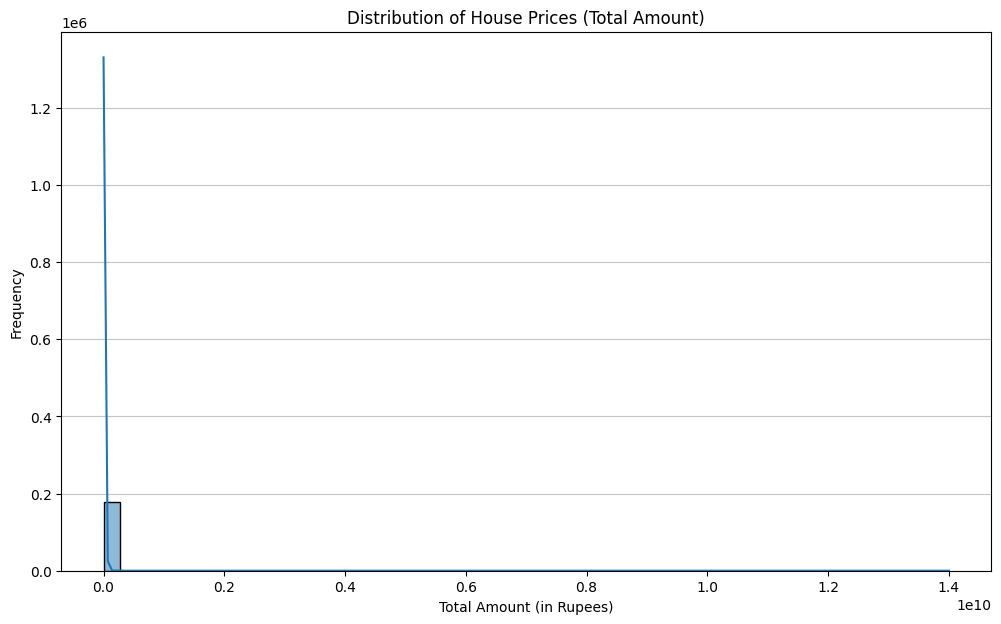

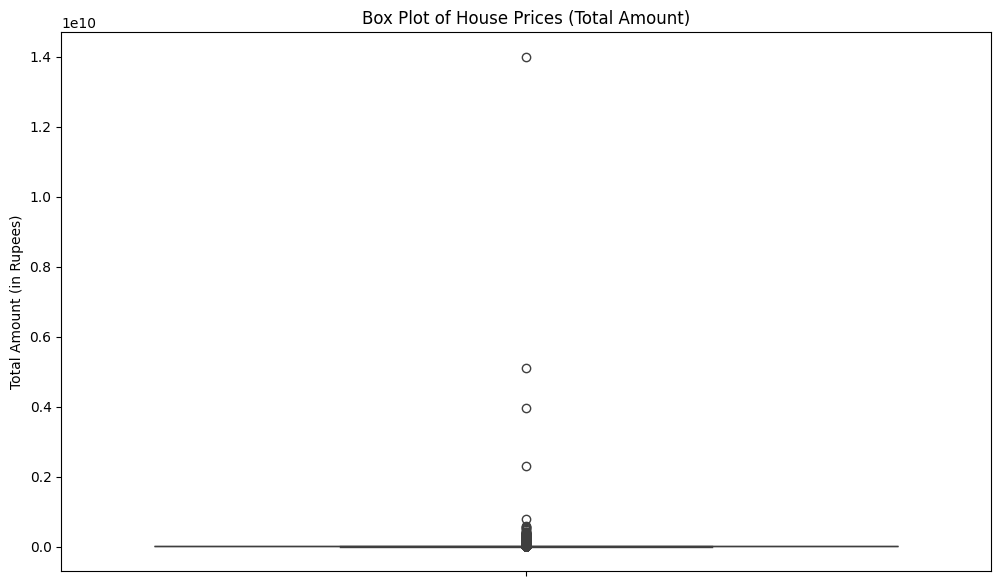


--- Distributions of Key Numerical Features ---


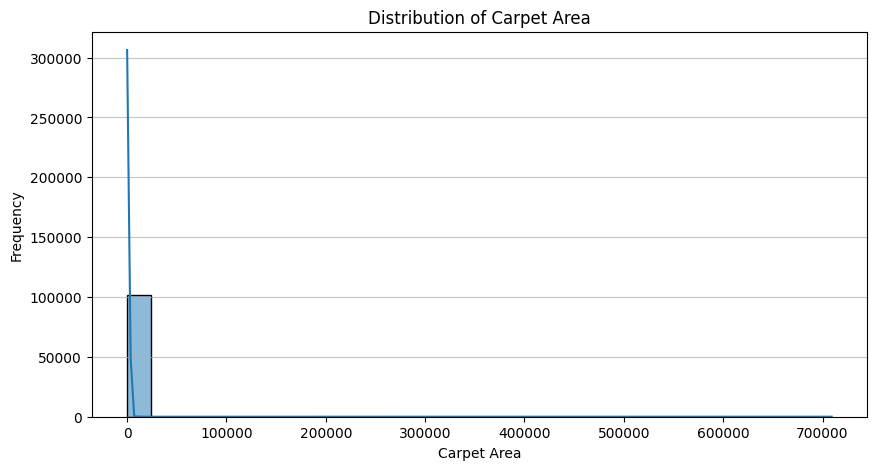

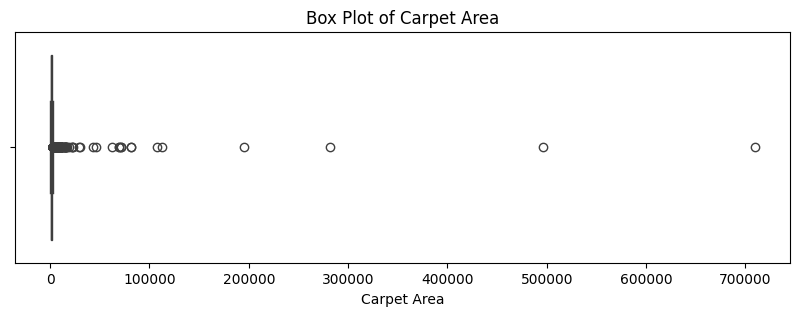

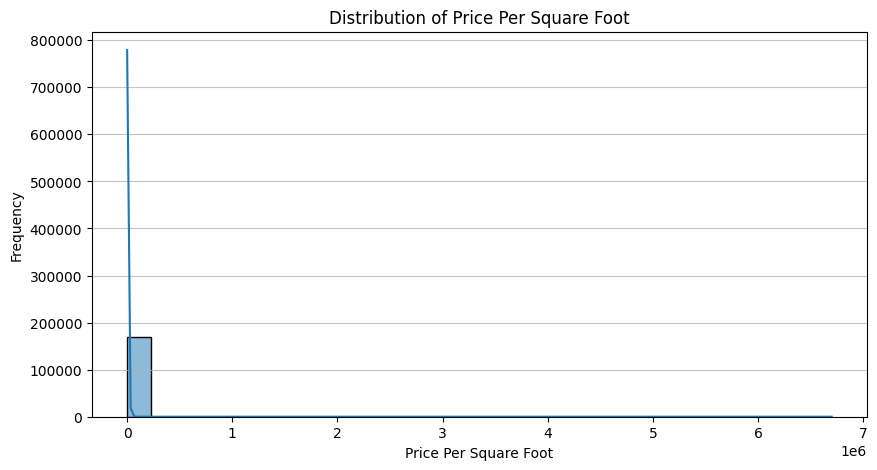

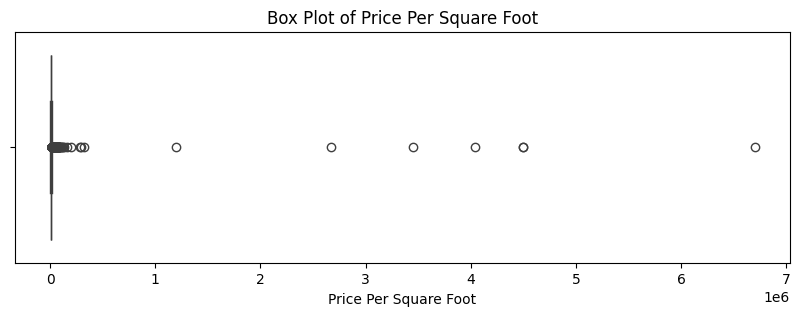

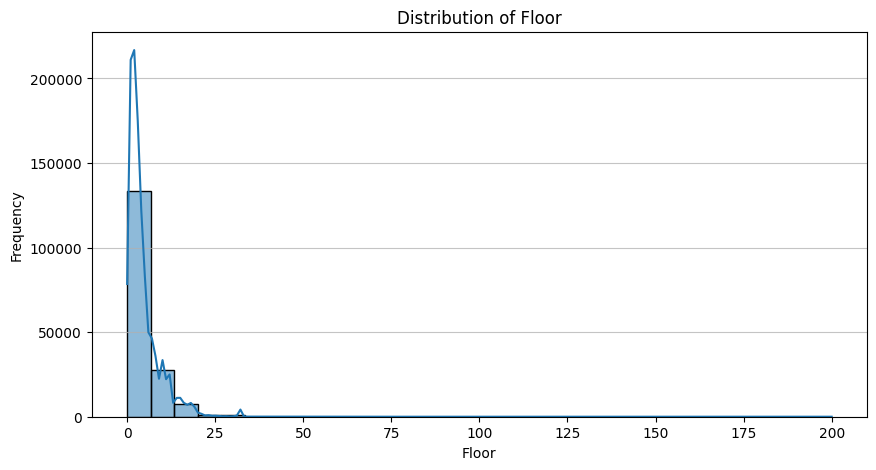

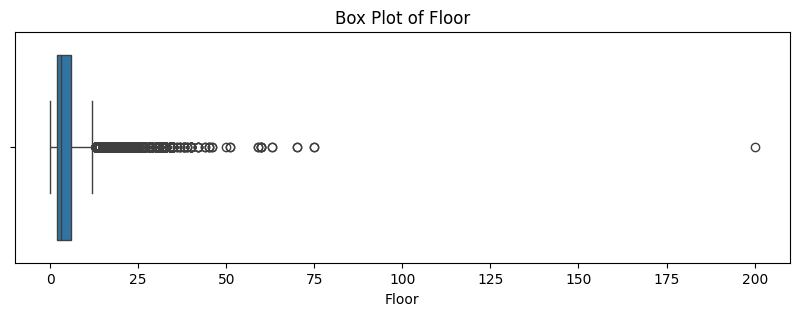

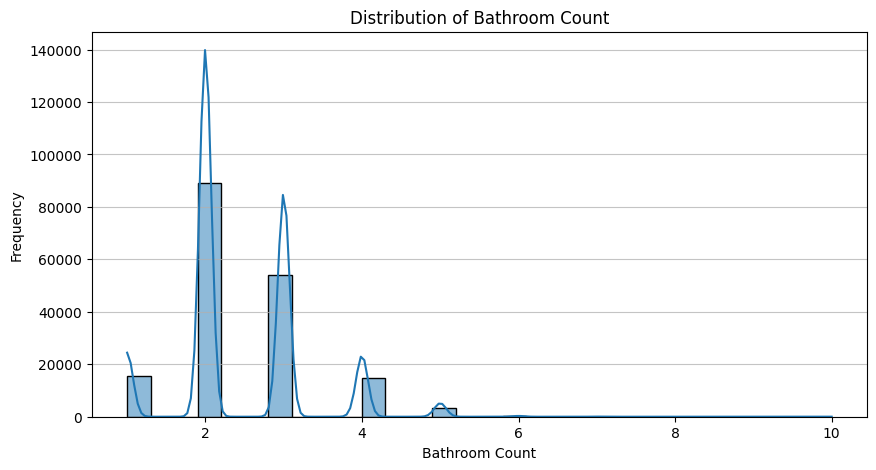

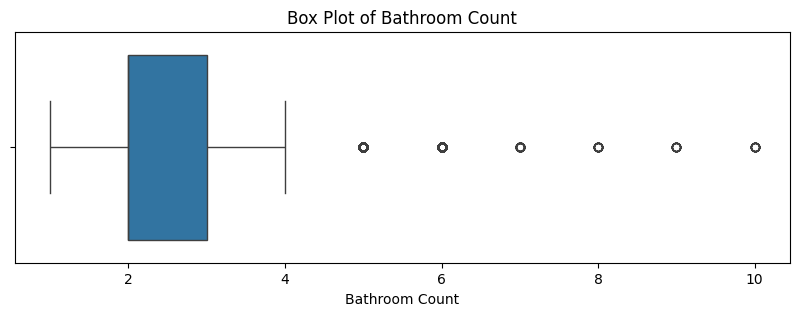

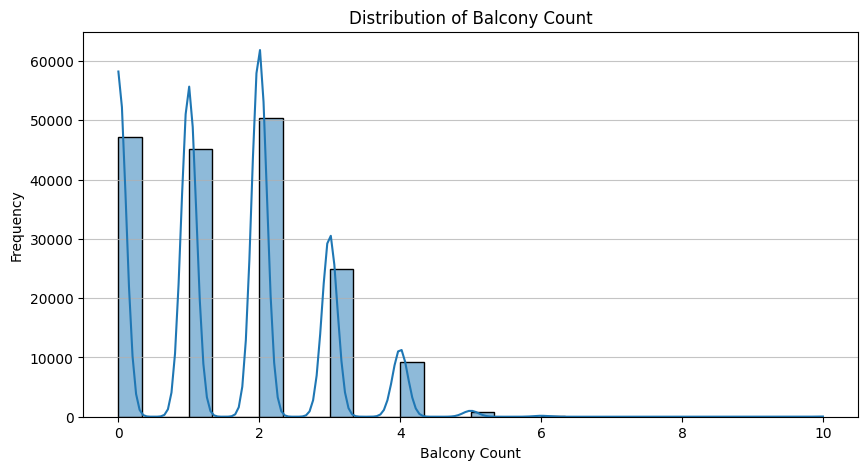

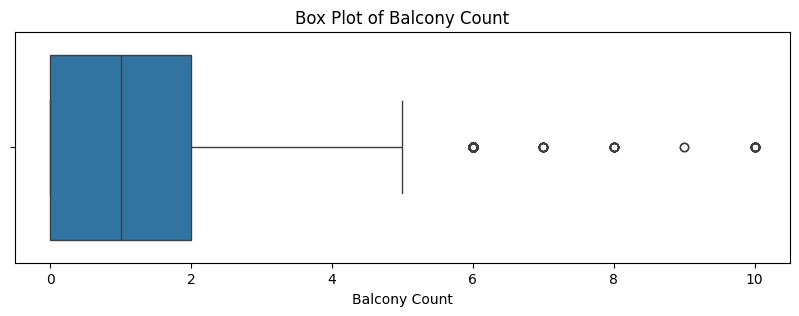

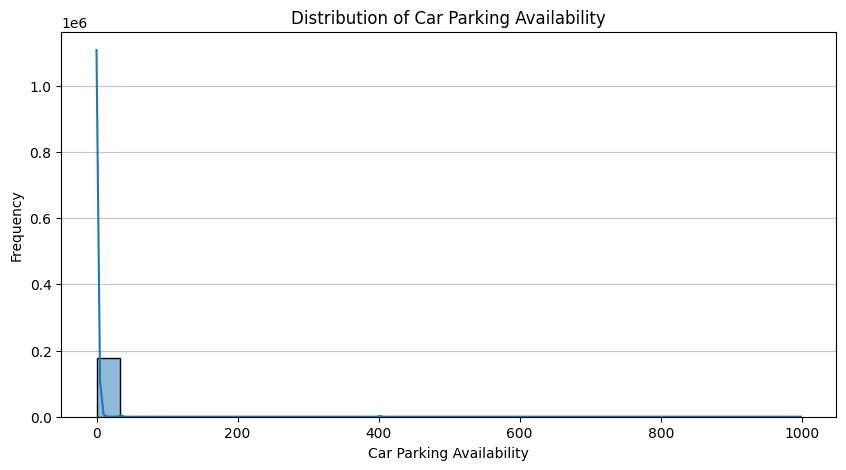

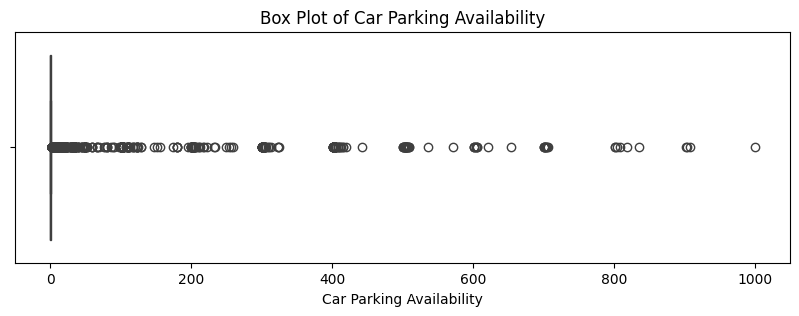

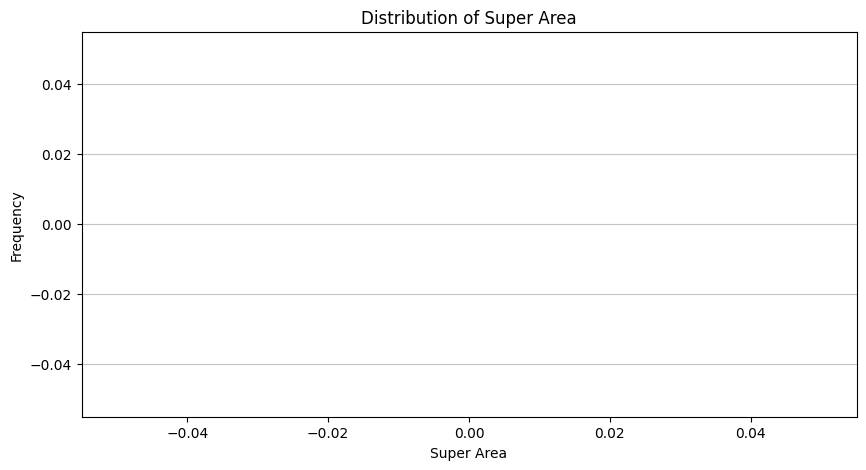

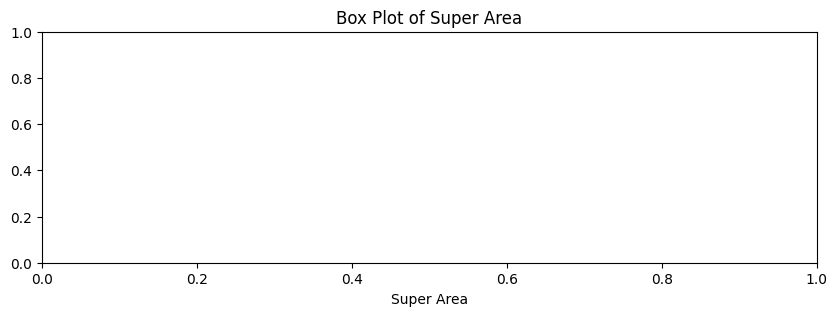

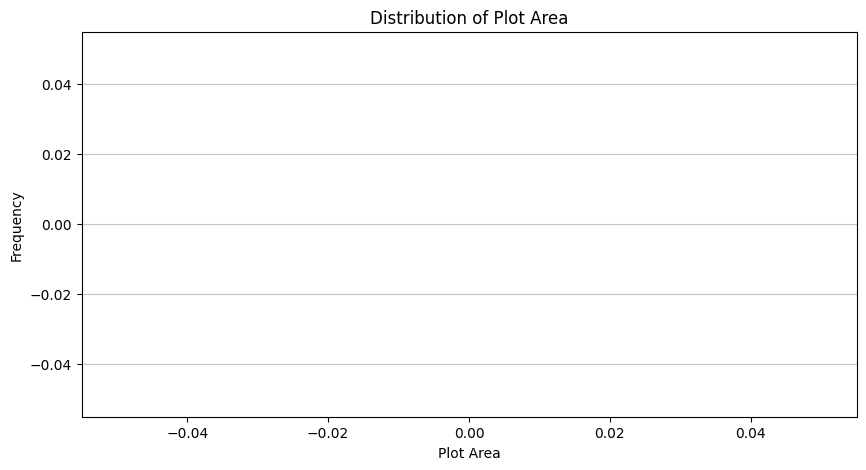

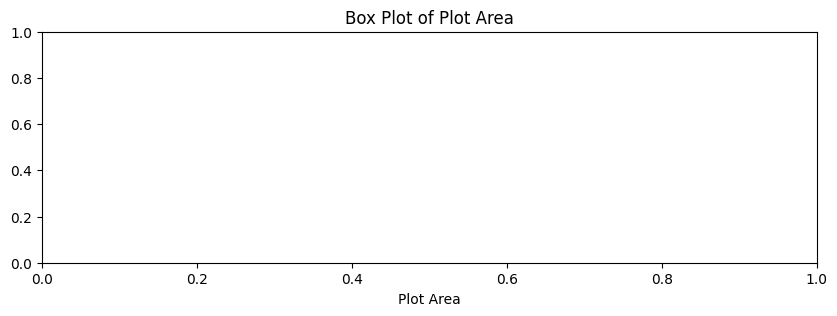


--- Distributions of Key Categorical Features ---


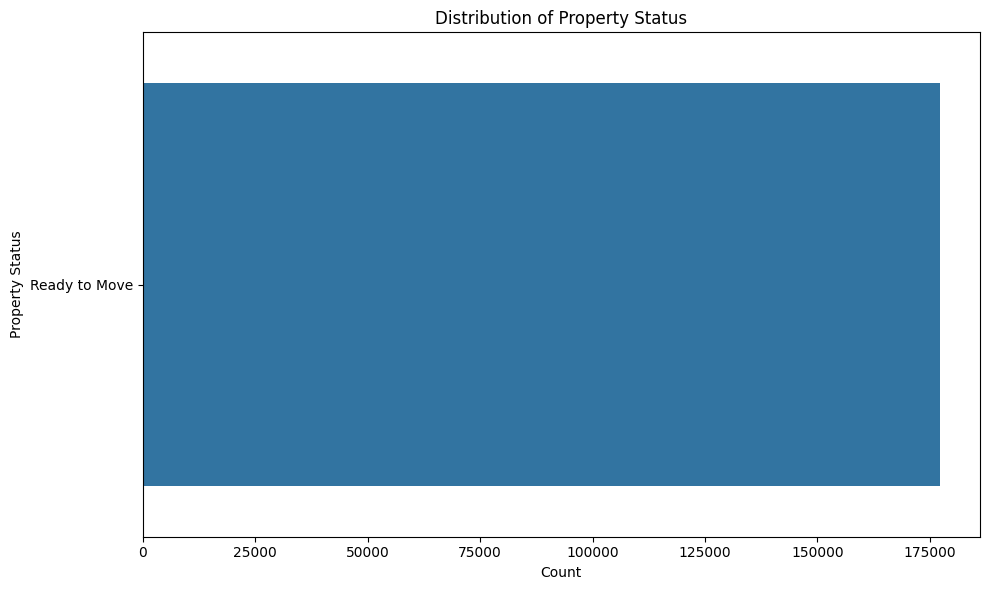

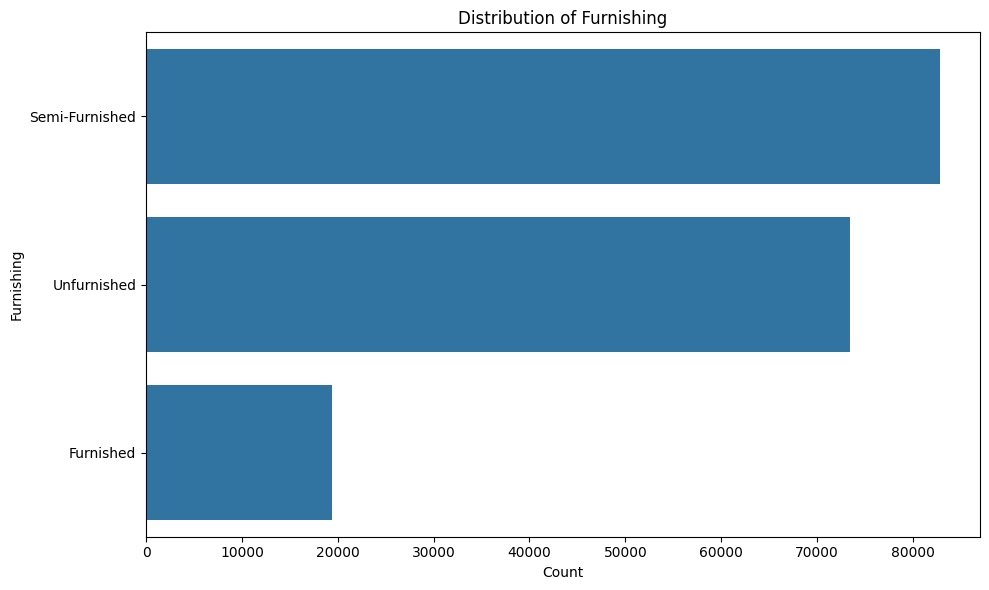

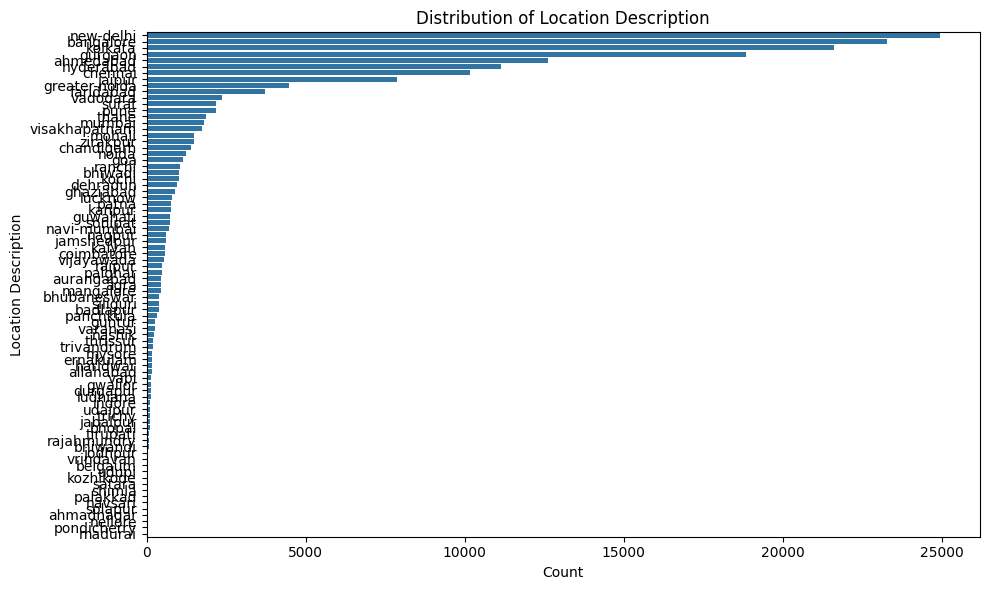

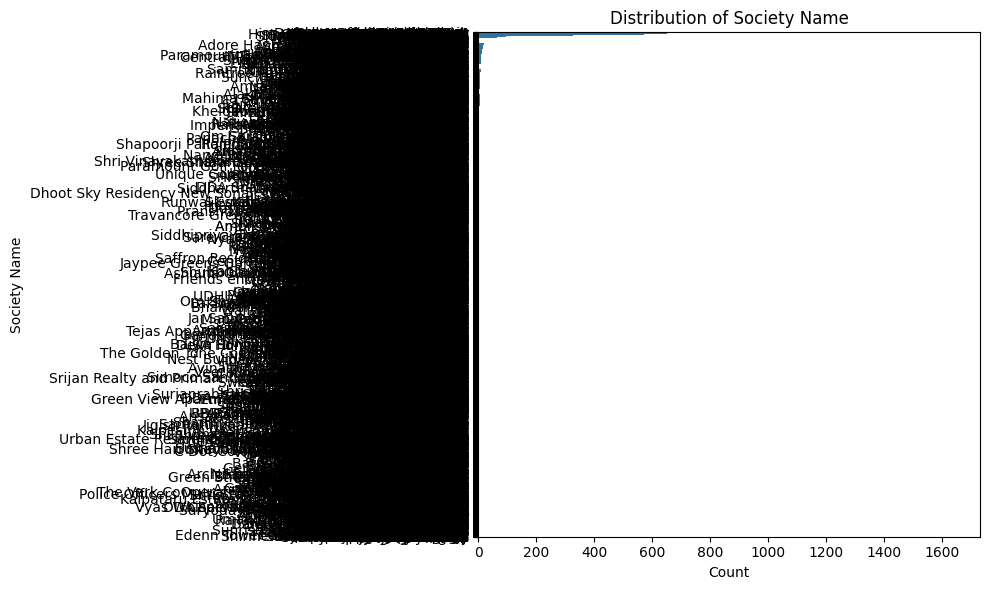


--- Bivariate Analysis: Features vs. Total Amount ---


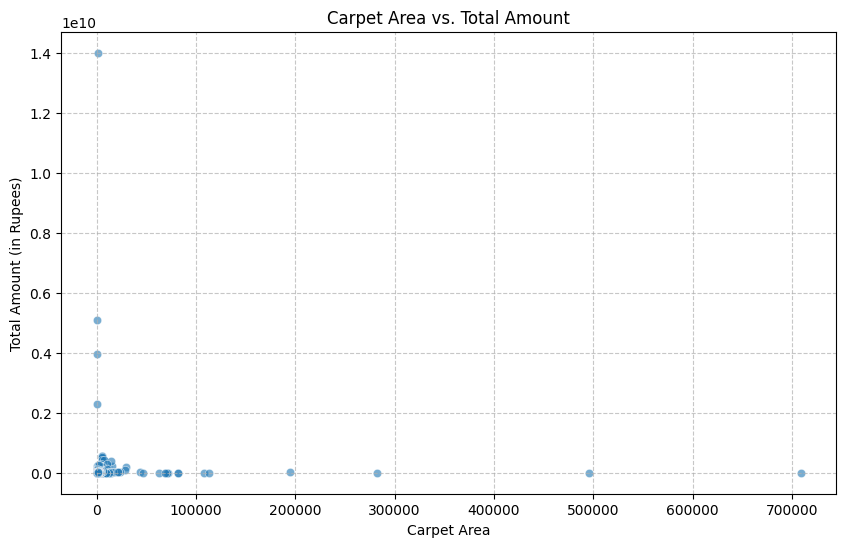

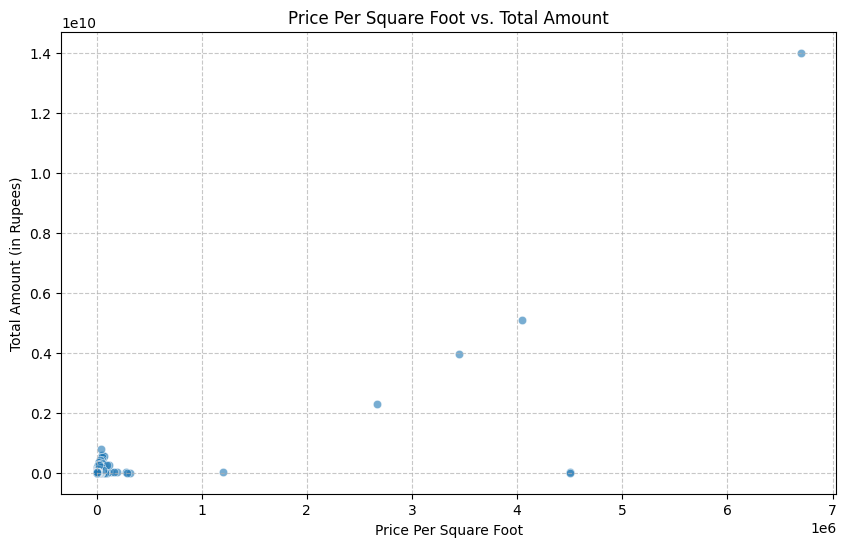

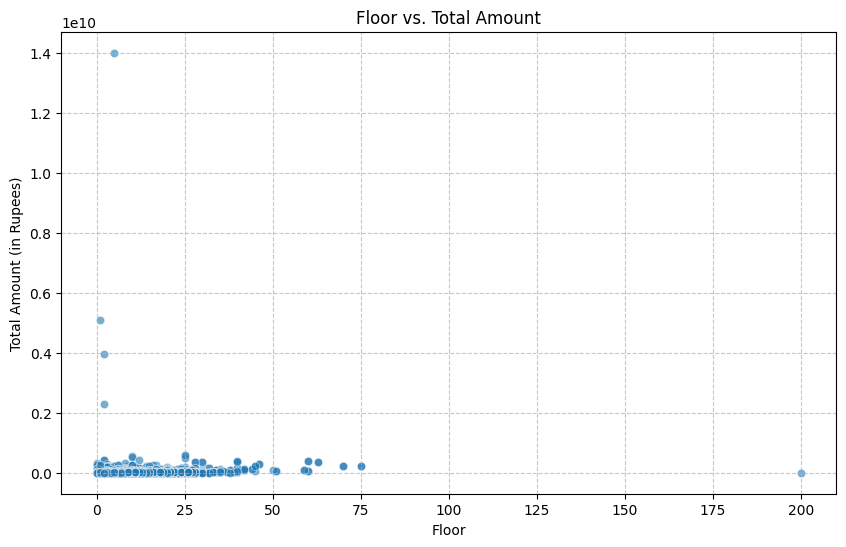

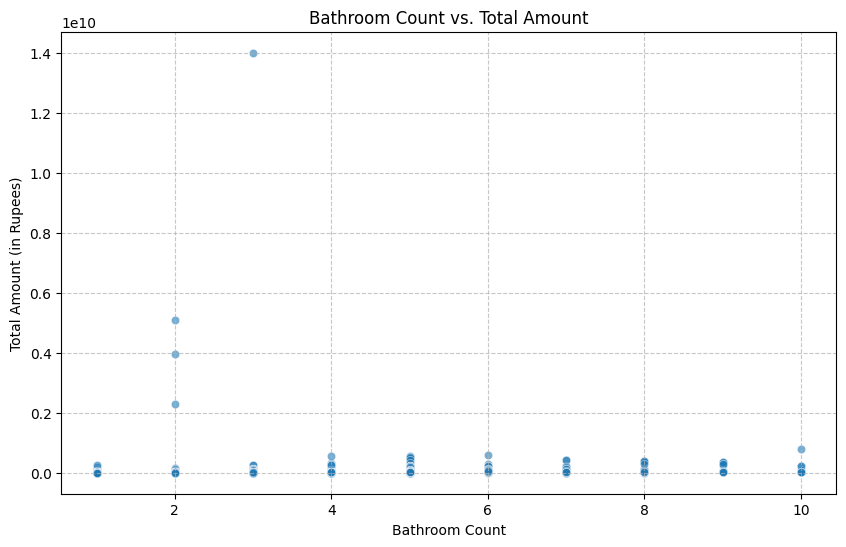

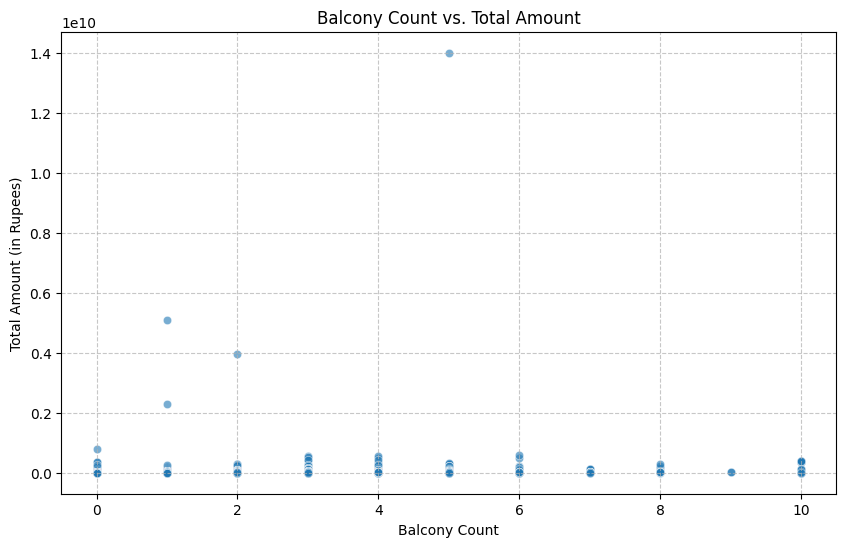

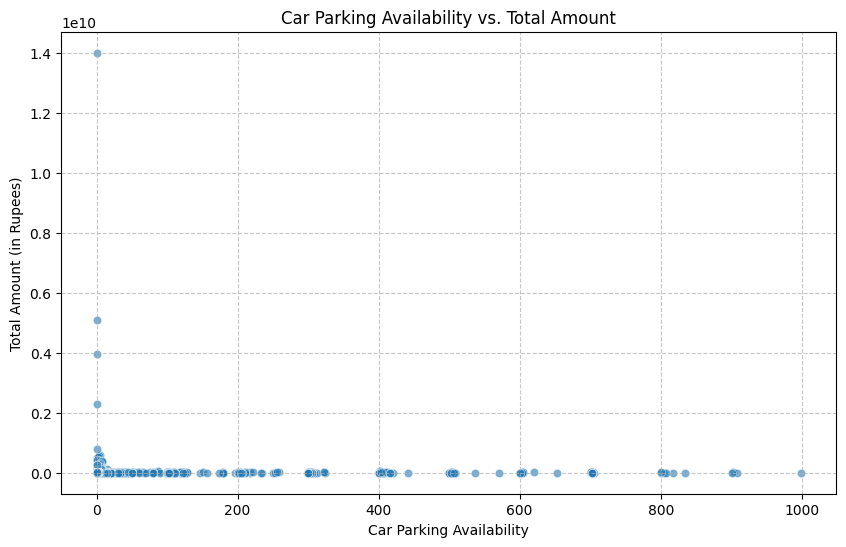

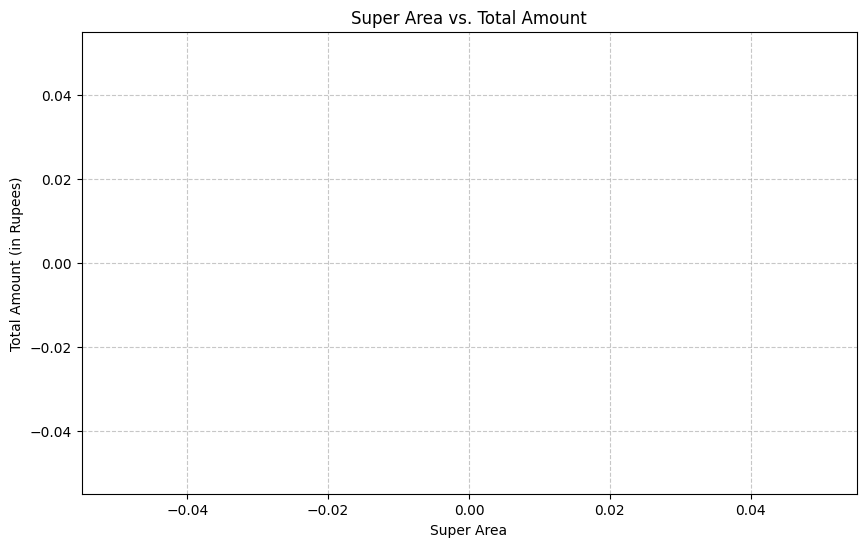

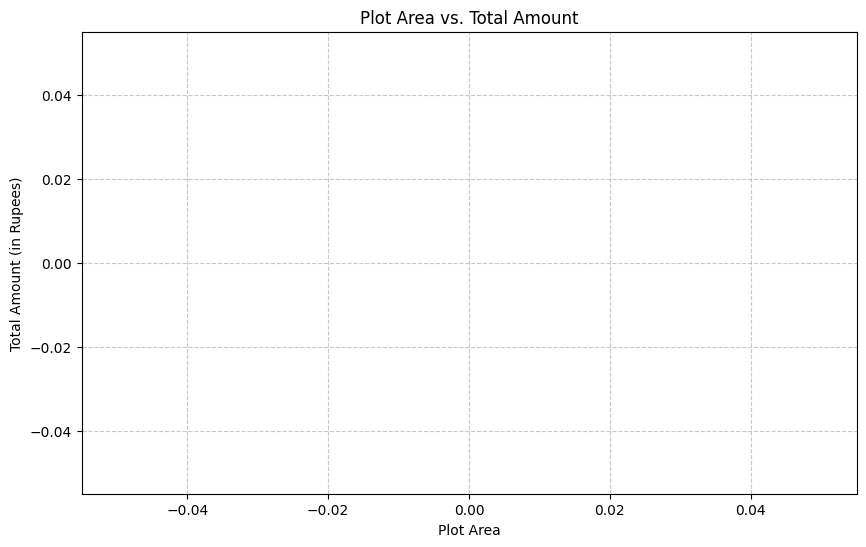

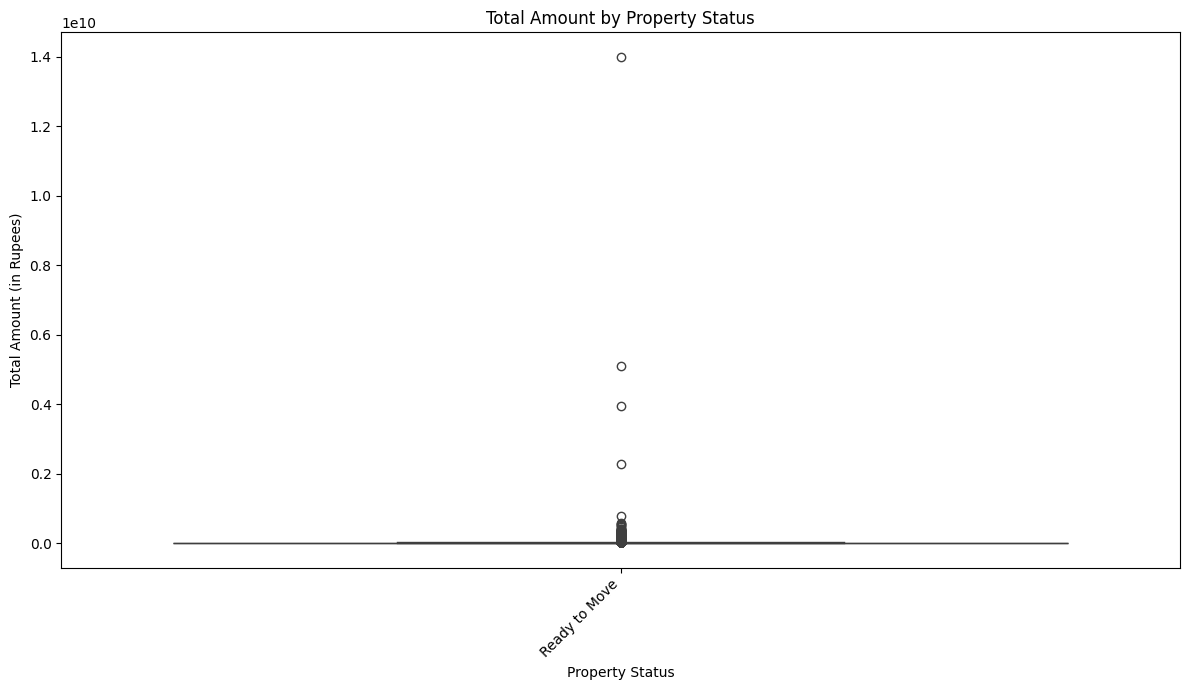

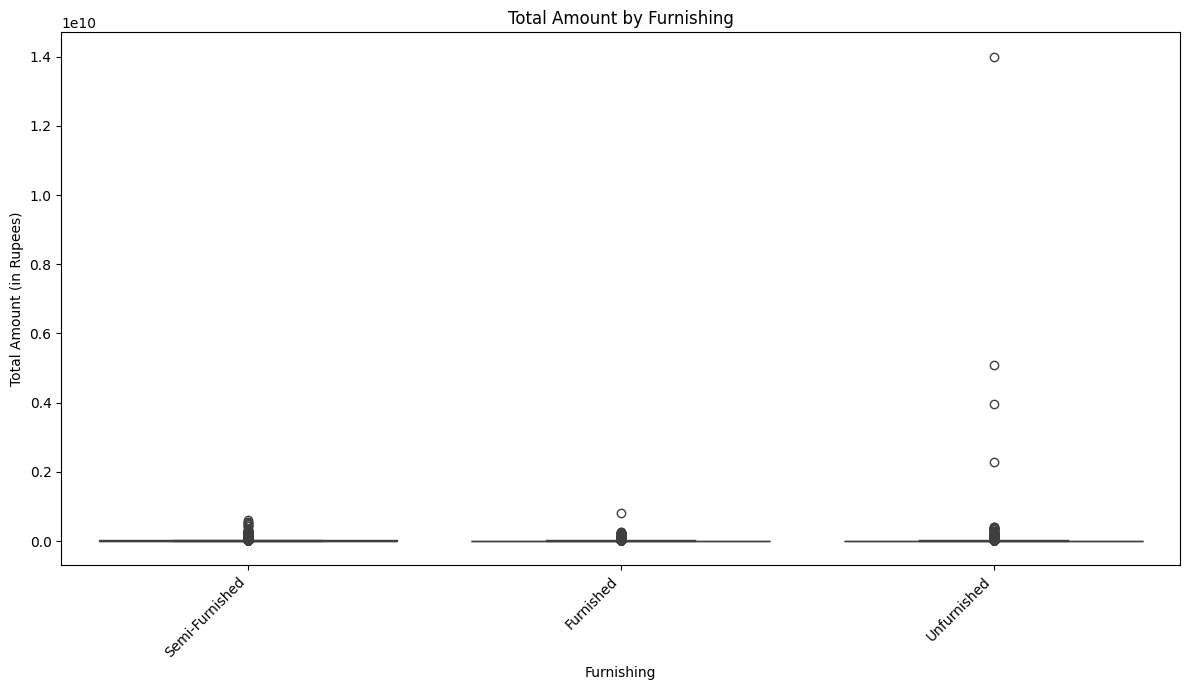


--- Multivariate Analysis: Correlation Matrix ---


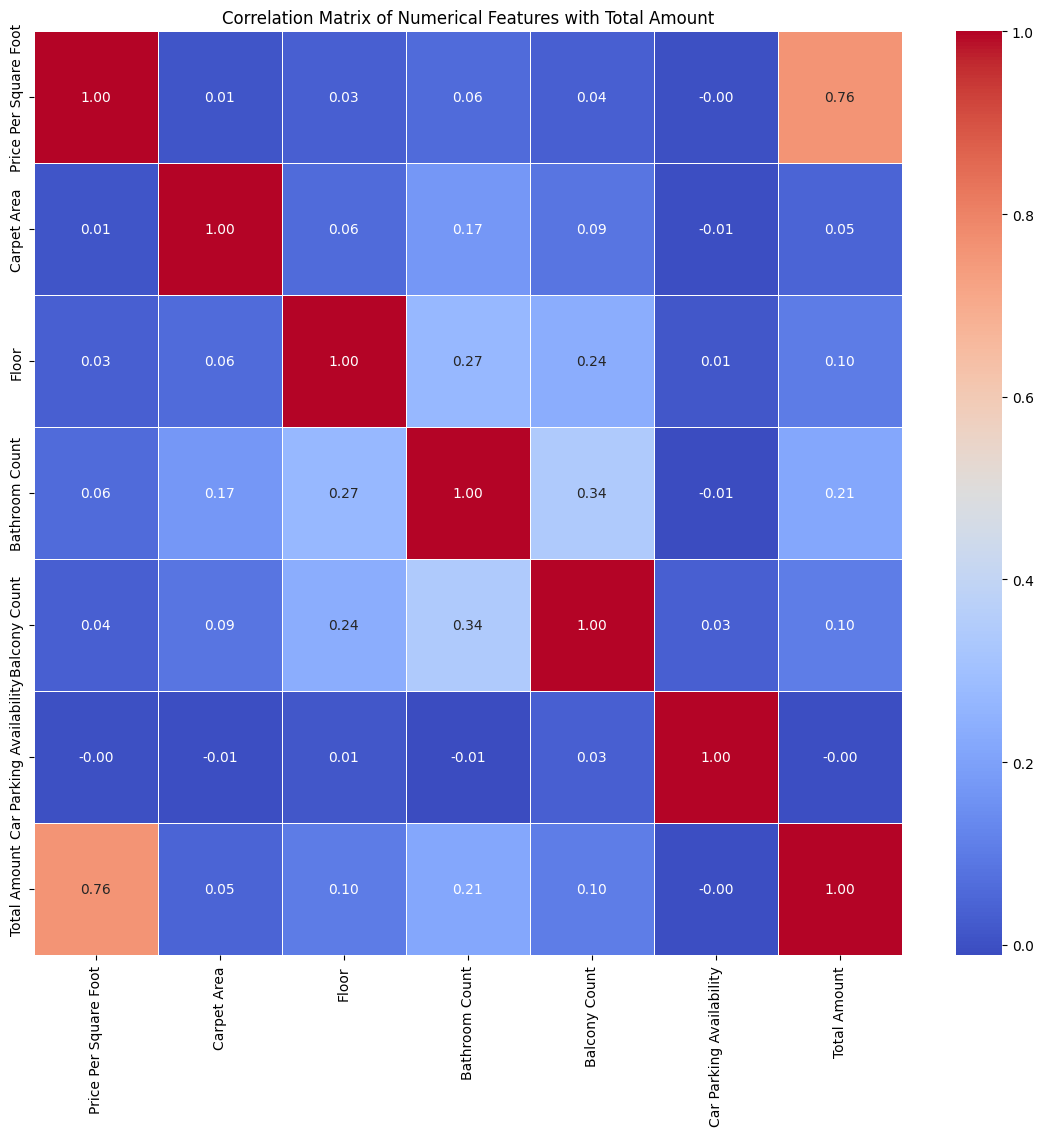


--- EDA Complete ---
Insights gained from EDA should guide further feature engineering or model selection.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Still useful if you want to reuse cleaning functions for ad-hoc checks
# Assuming your previous imports for data loading and basic cleaning are present
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer # Make sure this is imported if you're using it in preprocessing pipelines later

# --- Assuming df is already loaded and initial cleaning (renaming, type conversion for Total Amount, Carpet Area, Floor, Balcony, Car Parking) is done ---
# If you are running this as a standalone cell, ensure 'df' exists from previous steps,
# otherwise re-run the data loading and initial cleaning block first.
# For example, for demonstration purposes, let's assume 'df' is loaded like this:
# data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
# df = pd.read_csv(data_path)
# # ... (run your initial cleaning functions on df here if running isolated)

print("--- Starting Exploratory Data Analysis (EDA) ---")

# --- 2.1. Basic Data Overview (Post-initial cleaning) ---
print("\n--- Data Information (Post-Initial Cleaning) ---")
df.info()

print("\n--- Missing Values Count (Post-Initial Cleaning) ---")
print(df.isnull().sum())

print("\n--- Descriptive Statistics (Post-Initial Cleaning) ---")
print(df.describe())

# --- 2.2. Univariate Analysis (Distributions) ---

# Distribution of the Target Variable: 'Total Amount'
plt.figure(figsize=(12, 7))
sns.histplot(df['Total Amount'], kde=True, bins=50)
plt.title('Distribution of House Prices (Total Amount)')
plt.xlabel('Total Amount (in Rupees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(y=df['Total Amount'])
plt.title('Box Plot of House Prices (Total Amount)')
plt.ylabel('Total Amount (in Rupees)')
plt.show()
# Observation: Look for skewness and presence of outliers, which are common in price data.
# High values might be expensive properties, consider log transformation later if distribution is heavily skewed.


# Distribution of Key Numerical Features
numerical_features_for_eda = [
    'Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count',
    'Balcony Count', 'Car Parking Availability', 'Super Area', 'Plot Area'
]

print("\n--- Distributions of Key Numerical Features ---")
for col in numerical_features_for_eda:
    if col in df.columns and df[col].dtype in ['int64', 'float64']: # Ensure it's numerical
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col].dropna(), kde=True, bins=30) # Drop NaNs for plotting
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

        plt.figure(figsize=(10, 3))
        sns.boxplot(x=df[col].dropna())
        plt.title(f'Box Plot of {col}')
        plt.xlabel(col)
        plt.show()
    elif col in df.columns:
        print(f"Skipping {col} for numerical distribution plot: Not numeric after cleaning.")
    else:
        print(f"Warning: {col} not found in DataFrame for EDA.")


# Distribution of Key Categorical Features
categorical_features_for_eda = [
    'Property Status', 'Transaction Type', 'Furnishing', 'Facing',
    'Overlooking', 'Ownership Type', 'Property Title', 'Location Description', 'Society Name'
]

print("\n--- Distributions of Key Categorical Features ---")
for col in categorical_features_for_eda:
    if col in df.columns:
        plt.figure(figsize=(10, 6))
        # Use value_counts() to get counts and plot
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: {col} not found in DataFrame for EDA.")

# --- 2.3. Bivariate Analysis (Features vs. Target Variable) ---

print("\n--- Bivariate Analysis: Features vs. Total Amount ---")

# Numerical Features vs. Total Amount (Scatter Plots)
for col in numerical_features_for_eda:
    if col in df.columns and df[col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df[col], y=df['Total Amount'], alpha=0.6)
        plt.title(f'{col} vs. Total Amount')
        plt.xlabel(col)
        plt.ylabel('Total Amount (in Rupees)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    elif col in df.columns:
        print(f"Skipping {col} for scatter plot: Not numeric.")


# Categorical Features vs. Total Amount (Box Plots)
# Select a reasonable number of categories for plotting to avoid clutter
for col in ['Property Status', 'Transaction Type', 'Furnishing', 'Ownership Type', 'Facing']:
    if col in df.columns:
        plt.figure(figsize=(12, 7))
        # Order categories by median house price for better insight
        sorted_order = df.groupby(col)['Total Amount'].median().sort_values(ascending=False).index
        sns.boxplot(x=df[col], y=df['Total Amount'], order=sorted_order)
        plt.title(f'Total Amount by {col}')
        plt.xlabel(col)
        plt.ylabel('Total Amount (in Rupees)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: {col} not found in DataFrame for bivariate EDA.")

# For columns with many unique categories like 'Society Name' or 'Location Description',
# plotting all might be too much. Consider plotting top N categories or using aggregate statistics.
# Example for top N societies:
# if 'Society Name' in df.columns:
#     top_societies = df['Society Name'].value_counts().nlargest(10).index
#     plt.figure(figsize=(14, 8))
#     sns.boxplot(x=df[df['Society Name'].isin(top_societies)]['Society Name'],
#                 y=df['Total Amount'],
#                 order=df[df['Society Name'].isin(top_societies)].groupby('Society Name')['Total Amount'].median().sort_values(ascending=False).index)
#     plt.title('Total Amount by Top 10 Society Names')
#     plt.xticks(rotation=60, ha='right')
#     plt.tight_layout()
#     plt.show()


# --- 2.4. Multivariate Analysis (Correlation Matrix) ---

print("\n--- Multivariate Analysis: Correlation Matrix ---")

# Select only numerical columns for correlation calculation
# Ensure 'Total Amount' is also included here as it's the target
numerical_features_for_corr = df.select_dtypes(include=np.number).columns.tolist()

if 'Total Amount' not in numerical_features_for_corr:
    # This shouldn't happen if cleaning was done, but as a safeguard
    if 'Total Amount' in df.columns:
        numerical_features_for_corr.append('Total Amount')
    else:
        print("Warning: 'Total Amount' not found in numerical columns for correlation matrix.")

# Remove 'Total Amount' temporarily to put it at the end for visual clarity if desired
if 'Total Amount' in numerical_features_for_corr:
    numerical_features_for_corr.remove('Total Amount')
    numerical_features_for_corr.append('Total Amount') # Add it back at the end

if len(numerical_features_for_corr) >= 2: # Need at least two columns to calculate correlation
    plt.figure(figsize=(14, 12))
    # Calculate correlation matrix, dropping rows with any NaNs for correlation calculation
    correlation_matrix = df[numerical_features_for_corr].corr().dropna(how='all', axis=0).dropna(how='all', axis=1)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features with Total Amount')
    plt.show()
else:
    print("\nNot enough numerical features (at least 2) to plot a meaningful correlation matrix.")
    print(f"Numerical features available: {numerical_features_for_corr}")

print("\n--- EDA Complete ---")
print("Insights gained from EDA should guide further feature engineering or model selection.")

# Preprocessing again and changing target variable

In [29]:
import pandas as pd
import numpy as np
import re # For regular expressions to parse strings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Make sure this is imported!
# Assuming other imports (LinearRegression, Ridge, RandomForestRegressor, xgb) are already in your notebook

# --- 1. Data Loading (from your successful step) ---
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully for preprocessing!")
except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'. Please check the path.")
    exit()

# --- 2. Initial Data Cleaning and Feature Engineering (Specific to your dataset) ---
# This block is mostly unchanged from your previous successful run, just ensuring it's here for context.
print("\n--- Initial Data Cleaning and Feature Engineering ---")

# 2.1. Rename columns for consistency and clarity
df.rename(columns={
    'Amount(in rupees)': 'Total Amount', # Target variable
    'Price (in rupees)': 'Price Per Square Foot', # This seems to be price per sqft
    'Status': 'Property Status',
    'Bathroom': 'Bathroom Count',
    'Balcony': 'Balcony Count',
    'Car Parking': 'Car Parking Availability',
    'Society': 'Society Name',
    'location': 'Location Description',
    'facing': 'Facing', # Renamed as per prompt
    'overlooking': 'Overlooking', # Renamed as per prompt
    'Ownership': 'Ownership Type', # Renamed as per prompt
    'Transaction': 'Transaction Type' # Renamed as per prompt
}, inplace=True)
print("Columns renamed for consistency.")

# 2.2. Drop irrelevant columns
columns_to_drop = ['Index', 'Title', 'Description'] # Keep these as they were successfully dropped
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(f"Dropped columns: {columns_to_drop}")

# 2.3. Clean and convert 'Total Amount' (Target Variable)
def clean_amount(amount_str):
    if pd.isna(amount_str):
        return np.nan
    amount_str = str(amount_str).replace(' ', '').lower()
    if 'lac' in amount_str:
        return float(amount_str.replace('lac', '')) * 100000
    elif 'cr' in amount_str:
        return float(amount_str.replace('cr', '')) * 10000000
    else:
        try:
            return float(amount_str)
        except ValueError:
            return np.nan

df['Total Amount'] = df['Total Amount'].apply(clean_amount)
# Drop rows where 'Total Amount' is NaN, as these cannot be used for training/prediction
df.dropna(subset=['Total Amount'], inplace=True)
print("Cleaned 'Total Amount' column and removed rows with NaN target values.")


# 2.4. Clean and convert 'Carpet Area'
def clean_area_sqft(area_str):
    if pd.isna(area_str):
        return np.nan
    match = re.search(r'(\d+)', str(area_str)) # Extract digits
    if match:
        return float(match.group(1))
    return np.nan

df['Carpet Area'] = df['Carpet Area'].apply(clean_area_sqft)
print("Cleaned 'Carpet Area' column.")


# 2.5. Clean and convert 'Floor'
def clean_floor_number(floor_str):
    if pd.isna(floor_str):
        return np.nan
    # Handles 'X out of Y' format
    match = re.search(r'(\d+)\s+out\s+of\s+\d+', str(floor_str))
    if match:
        return float(match.group(1))
    # Handles cases like 'Ground', 'Lower Ground', 'Upper Ground'
    elif isinstance(floor_str, str) and 'ground' in floor_str.lower():
        return 0.0 # Assign 0 for ground floor
    # Handles direct numerical strings
    try:
        return float(floor_str)
    except ValueError:
        return np.nan

df['Floor'] = df['Floor'].apply(clean_floor_number)
print("Cleaned 'Floor' column to extract current floor number.")

# 2.6. Clean and convert 'Balcony Count'
def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str):
        return 0 # Assume 0 balconies if NaN, or impute later
    if isinstance(balcony_str, (int, float)): # Already a number
        return balcony_str
    match = re.search(r'(\d+)', str(balcony_str)) # Extract digits
    if match:
        return float(match.group(1))
    return 0 # Default to 0 if not parsable

df['Balcony Count'] = df['Balcony Count'].apply(clean_balcony_count)
print("Cleaned 'Balcony Count' column.")

# 2.7. Clean and convert 'Car Parking Availability'
def clean_parking_count(parking_str):
    if pd.isna(parking_str):
        return 0 # Assume 0 parking if NaN
    if isinstance(parking_str, (int, float)):
        return parking_str
    parking_str = str(parking_str).lower()
    if 'none' in parking_str or 'no' in parking_str:
        return 0
    match = re.search(r'(\d+)', parking_str)
    if match:
        return float(match.group(1))
    return 1 if 'available' in parking_str or 'yes' in parking_str else 0 # Assume 1 if just "Open" or "Covered"

df['Car Parking Availability'] = df['Car Parking Availability'].apply(clean_parking_count)
# Address the outlier '999' by capping it at a reasonable maximum, e.g., 5
df['Car Parking Availability'] = df['Car Parking Availability'].clip(upper=5)
print("Cleaned 'Car Parking Availability' column and capped outliers.")


# 2.8. Ensure numerical columns are truly numeric where possible, if they were loaded as objects
for col in ['Price Per Square Foot', 'Bathroom Count']: # 'Super Area', 'Dimensions', 'Plot Area' are now explicitly dropped
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric, force non-numeric to NaN
print("Ensured numerical columns are numeric.")

# --- 3. Define Features and Preprocessing Pipeline ---

# Re-identify numerical and categorical features after cleaning and renaming
# IMPORTANT: 'Super Area', 'Dimensions', 'Plot Area' are NOT included here as they are all NaN
numerical_features = [
    'Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count',
    'Balcony Count', 'Car Parking Availability'
]
categorical_features = [
    'Property Status', 'Transaction Type', 'Furnishing', 'Facing',
    'Overlooking', 'Society Name', 'Ownership Type', 'Property Title', 'Location Description'
]

# Filter features to only include those present in the DataFrame after all drops/renames
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

print(f"\nFinal Features selected for modeling:")
print(f"Numerical: {numerical_features}")
print(f"Categorical: {categorical_features}")

# Separate target variable (Total Amount)
X = df.drop('Total Amount', axis=1)
y = df['Total Amount']

# --- OPTIONAL but RECOMMENDED: Log Transform the target variable ---
# This helps normalize highly skewed target distributions and can improve model performance
# especially for models like Linear Regression or Ridge.
y = np.log1p(y) # log1p means log(1+x), handles zero values gracefully
print("\nTarget variable 'Total Amount' has been log-transformed (np.log1p).")


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape after splitting: {X_train.shape}")
print(f"Testing set shape after splitting: {X_test.shape}")
print(f"Target variable (y_train) min after log transform: {y_train.min():.2f}")
print(f"Target variable (y_train) max after log transform: {y_train.max():.2f}")


# Define preprocessing steps within ColumnTransformer
# For numerical features: Impute NaNs with median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: Impute NaNs with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Explicitly drop any columns not specified (like 'Super Area', 'Dimensions', 'Plot Area')
)

print("\nPreprocessing pipeline created successfully!")
print("You are now ready to train your models using this 'preprocessor' within a Scikit-learn Pipeline.")

# --- Continue with Model Development and Training as before ---
# Example for Linear Regression pipeline:
# pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
# pipeline_lr.fit(X_train, y_train)
# # Remember to inverse transform predictions for evaluation if you log-transformed y!
# y_pred_lr_log = pipeline_lr.predict(X_test)
# y_pred_lr = np.expm1(y_pred_lr_log) # inverse transform for evaluation
# # Then evaluate using evaluate_model(y_test_original, y_pred_lr, "Linear Regression")
# # You'll need to inverse transform y_test as well, or pass the original y_test values to evaluation.
# # It's easier to pass np.expm1(y_test) to the evaluation function along with the inverse transformed predictions.

Dataset loaded successfully for preprocessing!

--- Initial Data Cleaning and Feature Engineering ---
Columns renamed for consistency.
Dropped columns: ['Index', 'Title', 'Description']
Cleaned 'Total Amount' column and removed rows with NaN target values.
Cleaned 'Carpet Area' column.
Cleaned 'Floor' column to extract current floor number.
Cleaned 'Balcony Count' column.
Cleaned 'Car Parking Availability' column and capped outliers.
Ensured numerical columns are numeric.

Final Features selected for modeling:
Numerical: ['Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count', 'Balcony Count', 'Car Parking Availability']
Categorical: ['Property Status', 'Transaction Type', 'Furnishing', 'Facing', 'Overlooking', 'Society Name', 'Ownership Type', 'Location Description']

Target variable 'Total Amount' has been log-transformed (np.log1p).

Training set shape after splitting: (142277, 17)
Testing set shape after splitting: (35570, 17)
Target variable (y_train) min after log tran

# Second Round of EDA: Post-Cleaning & Target Transformation 

Dataset loaded successfully for preprocessing!

--- Initial Data Cleaning and Feature Engineering ---
Columns renamed for consistency.
Dropped columns: ['Index', 'Title', 'Description']
Cleaned 'Total Amount' column and removed rows with NaN target values.
Cleaned 'Carpet Area' column.
Cleaned 'Floor' column to extract current floor number.
Cleaned 'Balcony Count' column.
Cleaned 'Car Parking Availability' column and capped outliers.
Ensured numerical columns are numeric.

Final Features selected for modeling:
Numerical: ['Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count', 'Balcony Count', 'Car Parking Availability']
Categorical: ['Property Status', 'Transaction Type', 'Furnishing', 'Facing', 'Overlooking', 'Society Name', 'Ownership Type', 'Location Description']

Target variable 'Total Amount' has been log-transformed (np.log1p).

Training set shape after splitting: (142277, 17)
Testing set shape after splitting: (35570, 17)
Target variable (y_train) min after log tran

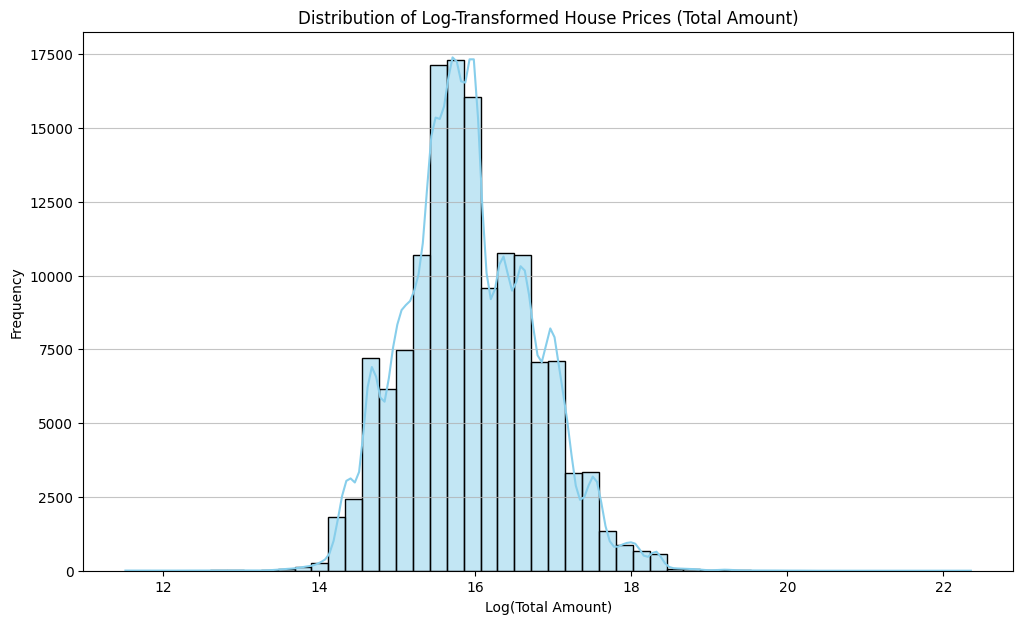

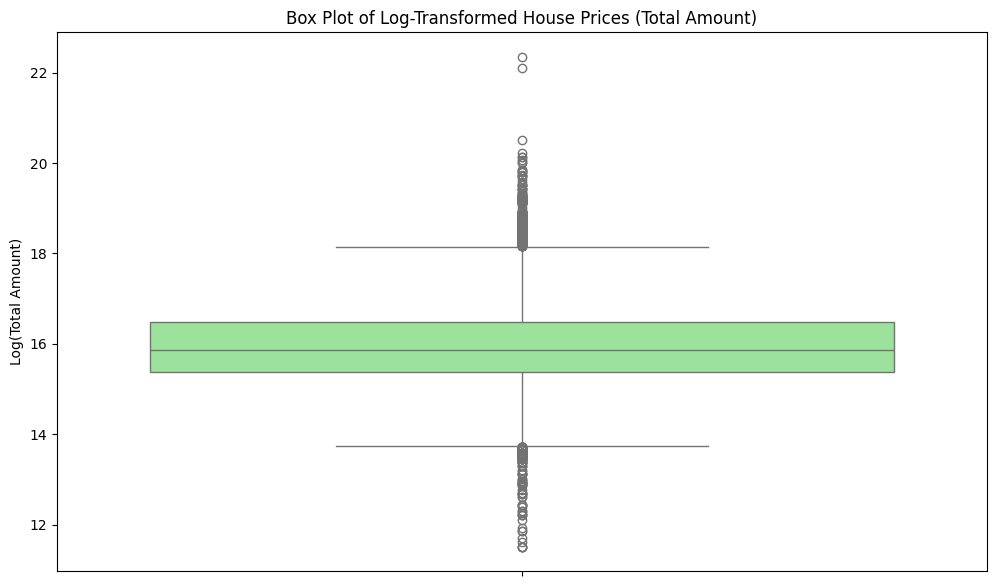

Observed log-transformed target variable distribution. It should be more symmetrical now.

--- Distributions of Key Numerical Features (Post-Initial Cleaning & Capping) ---


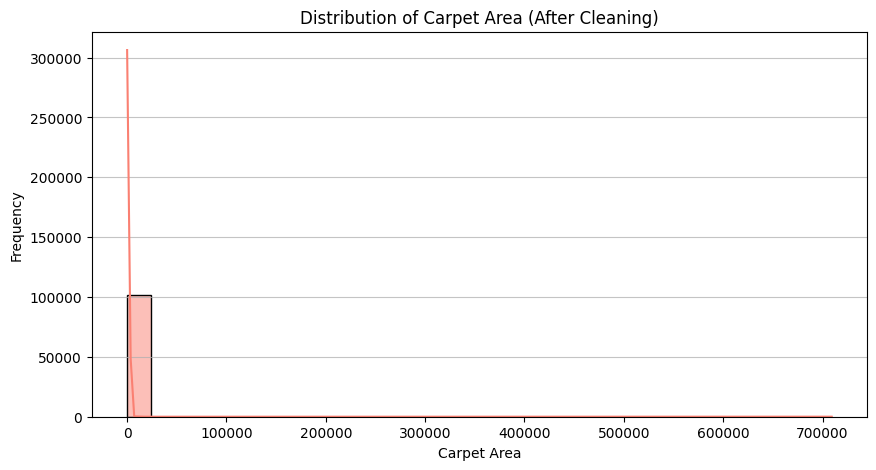

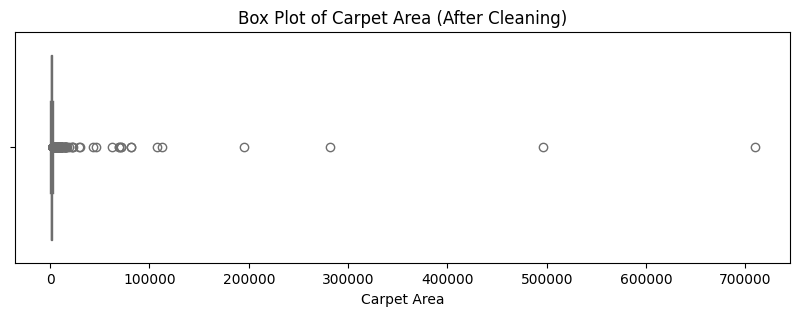

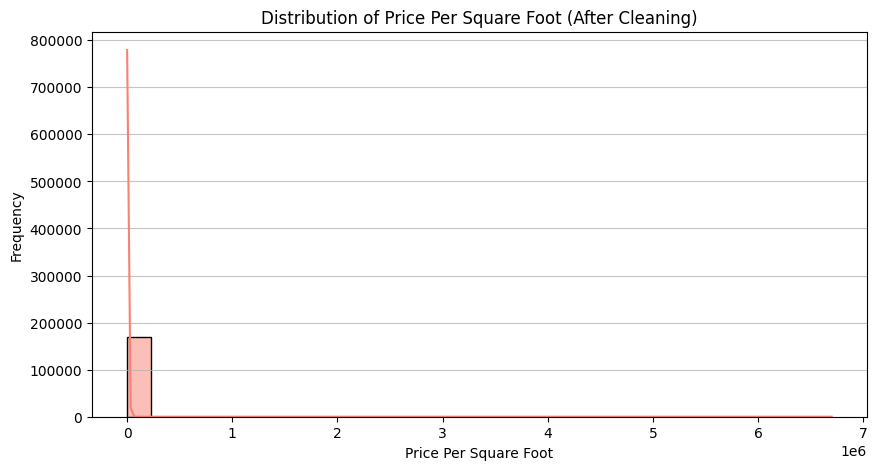

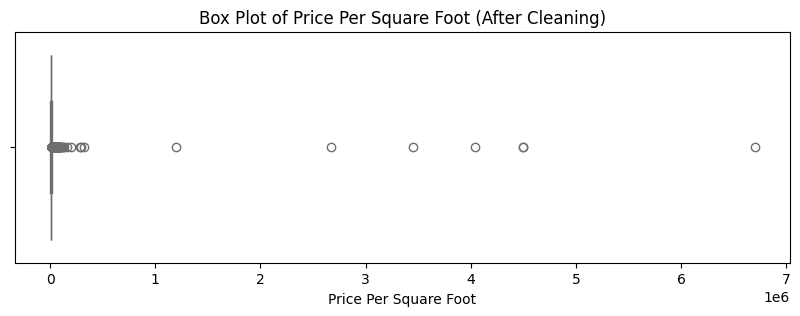

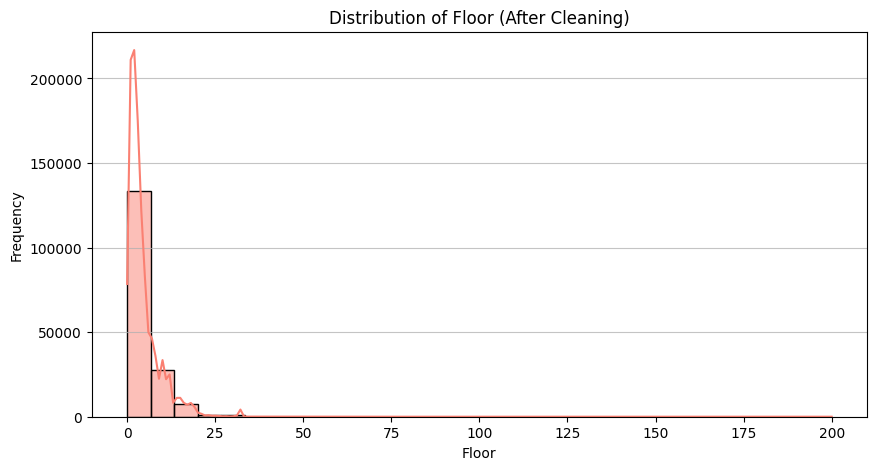

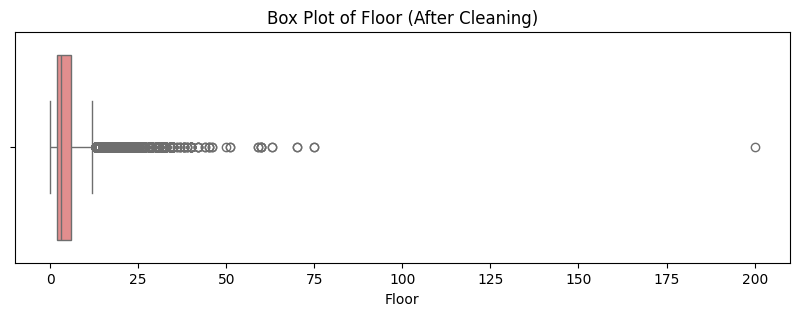

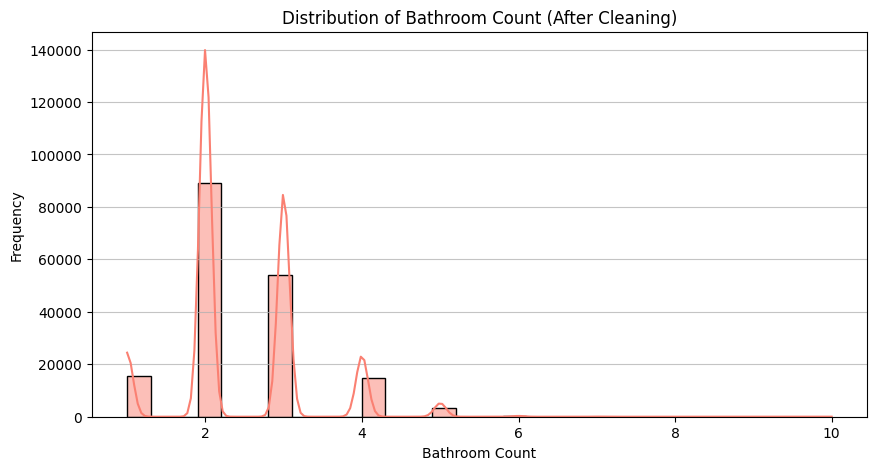

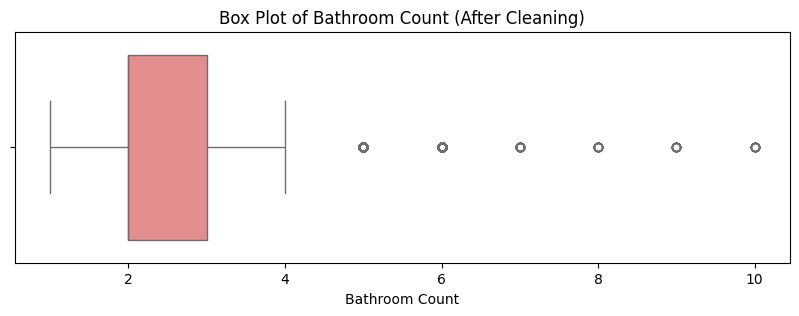

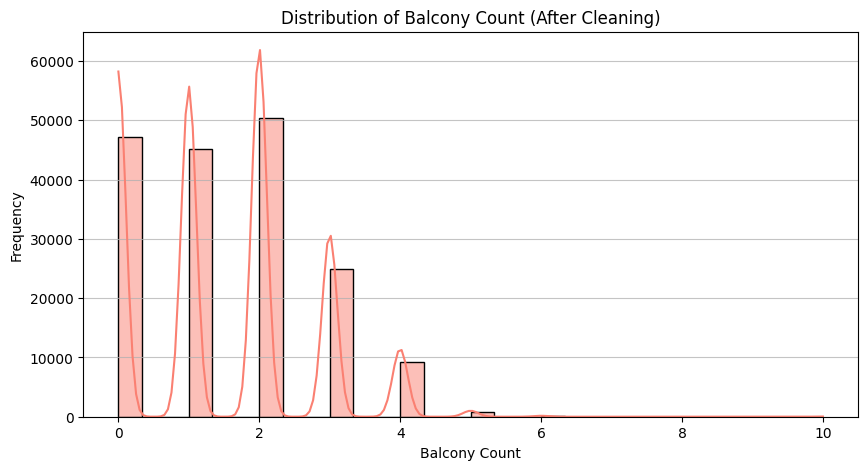

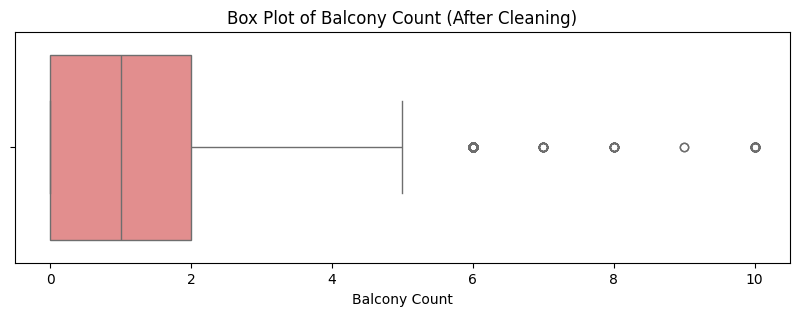

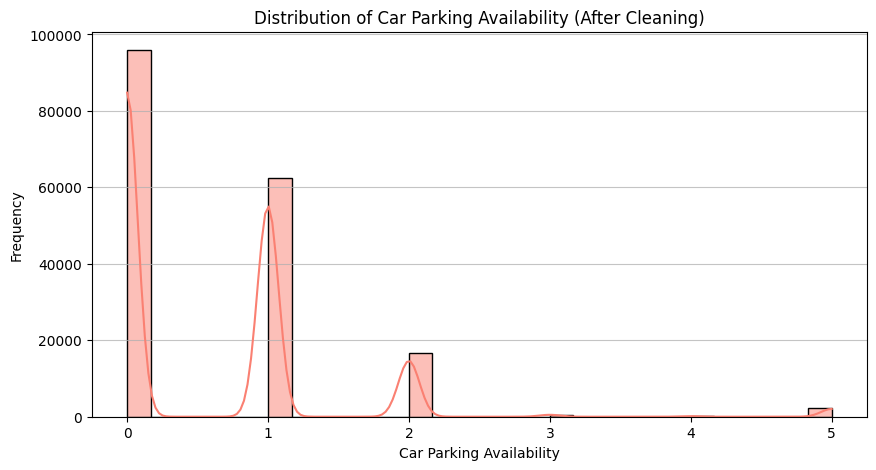

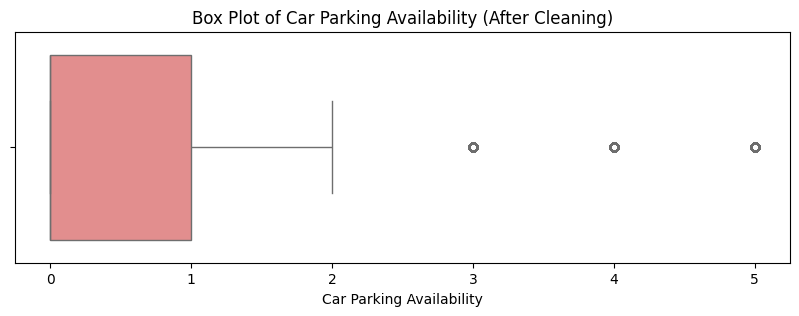


--- Bivariate Analysis: Numerical Features vs. Log(Total Amount) ---


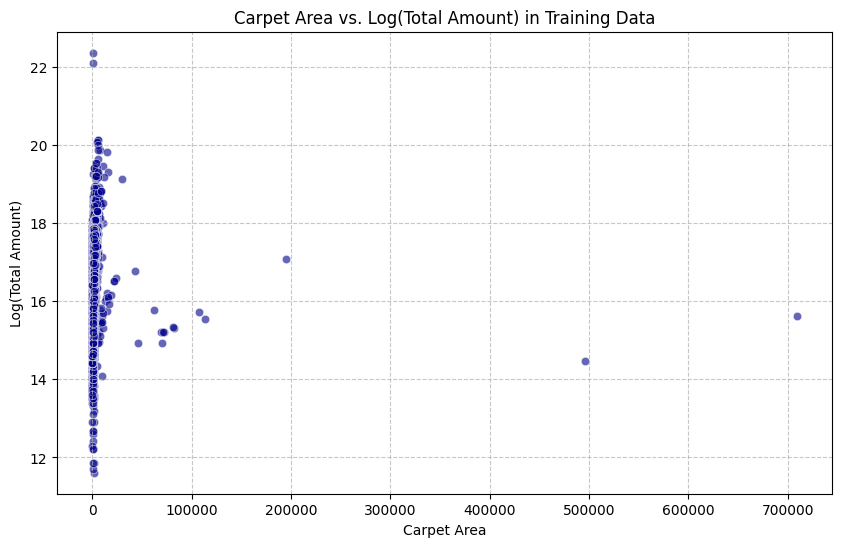

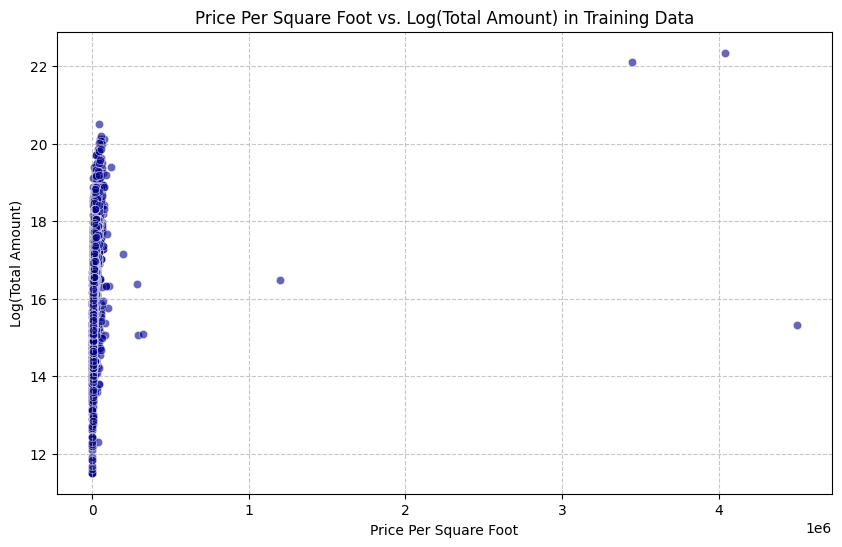

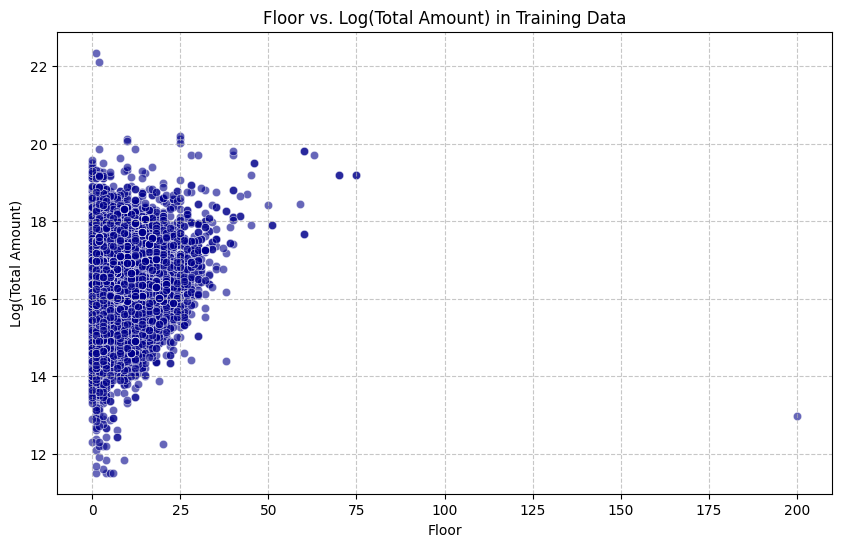

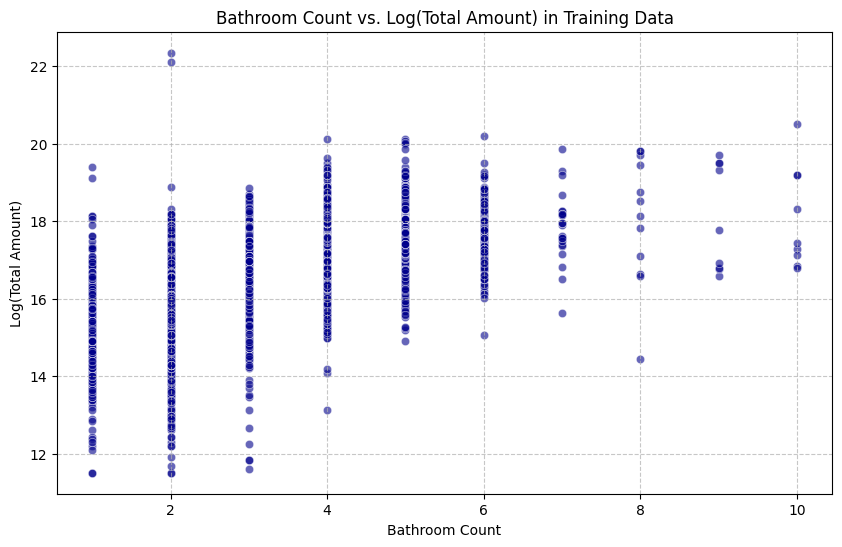

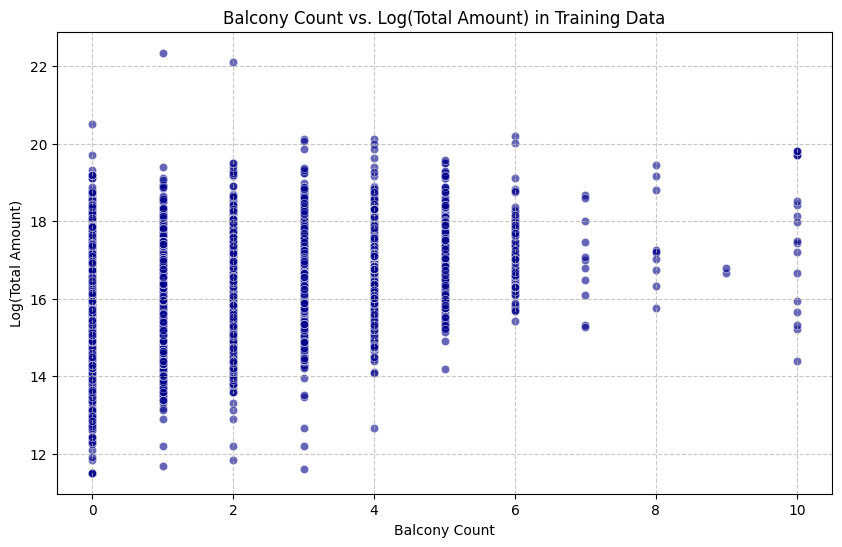

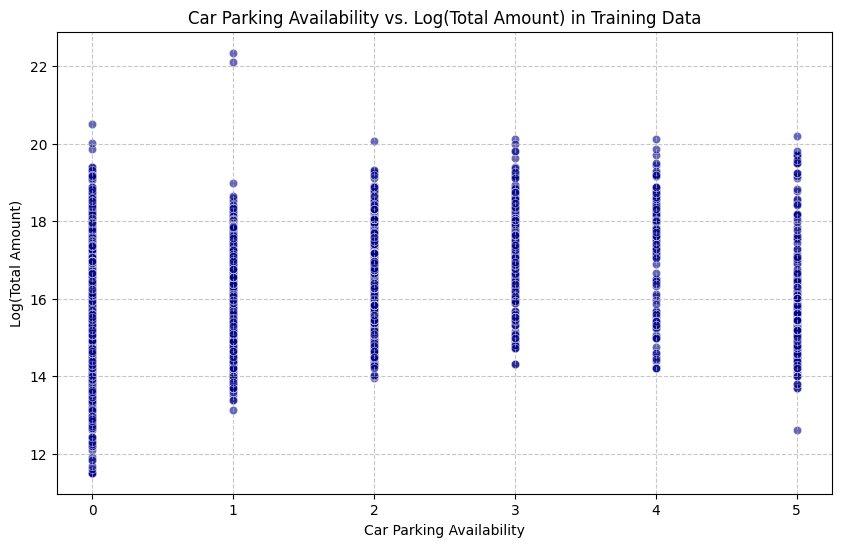


--- Bivariate Analysis: Categorical Features vs. Log(Total Amount) ---


C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=plot_df[col], y=plot_df['Log_Total_Amount'], order=sorted_order, palette='viridis')


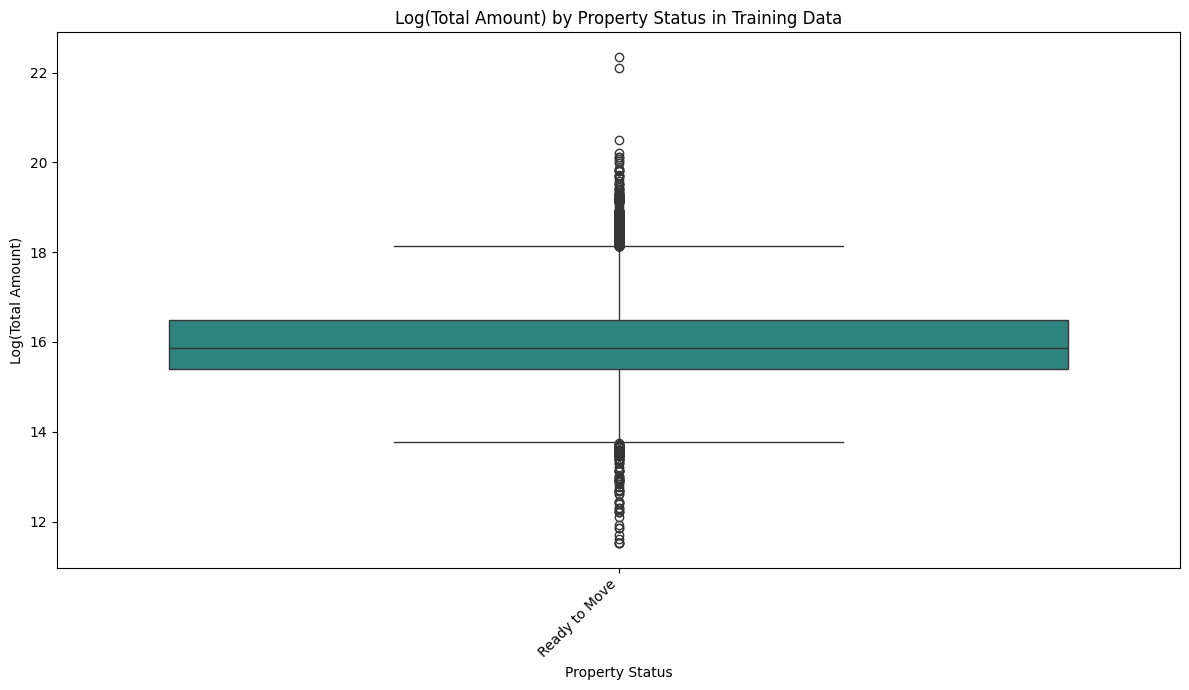

C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=plot_df[col], y=plot_df['Log_Total_Amount'], order=sorted_order, palette='viridis')


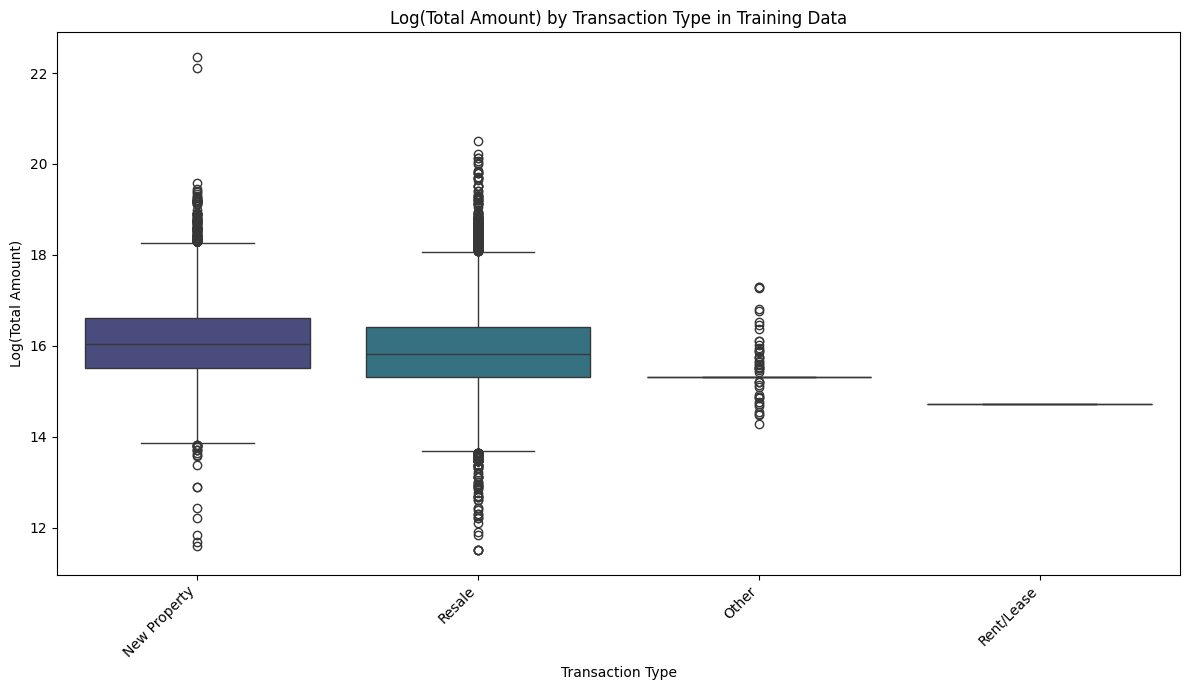

C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=plot_df[col], y=plot_df['Log_Total_Amount'], order=sorted_order, palette='viridis')


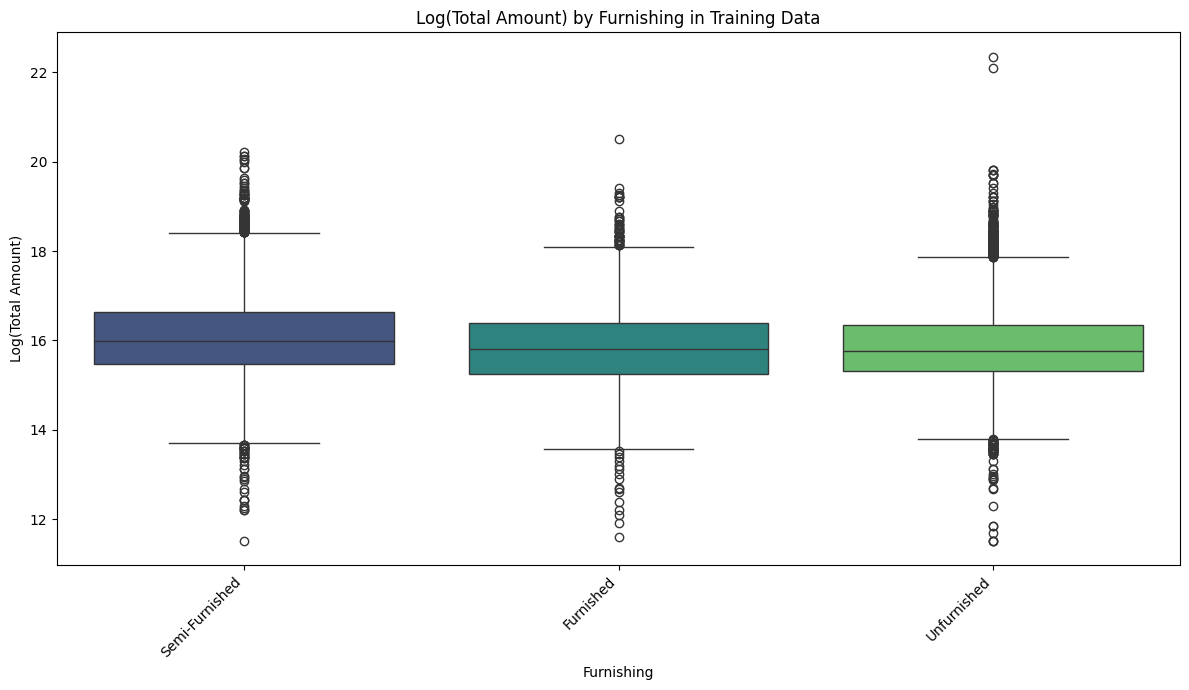

C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=plot_df[col], y=plot_df['Log_Total_Amount'], order=sorted_order, palette='viridis')


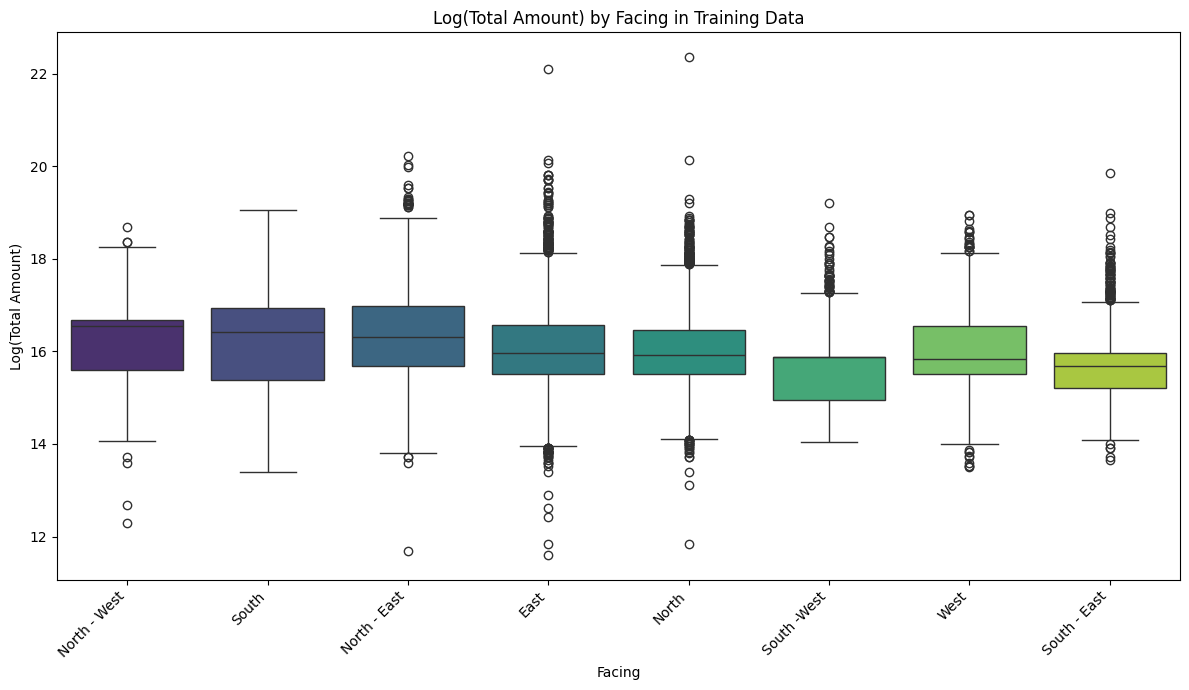

C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=plot_df[col], y=plot_df['Log_Total_Amount'], order=sorted_order, palette='viridis')


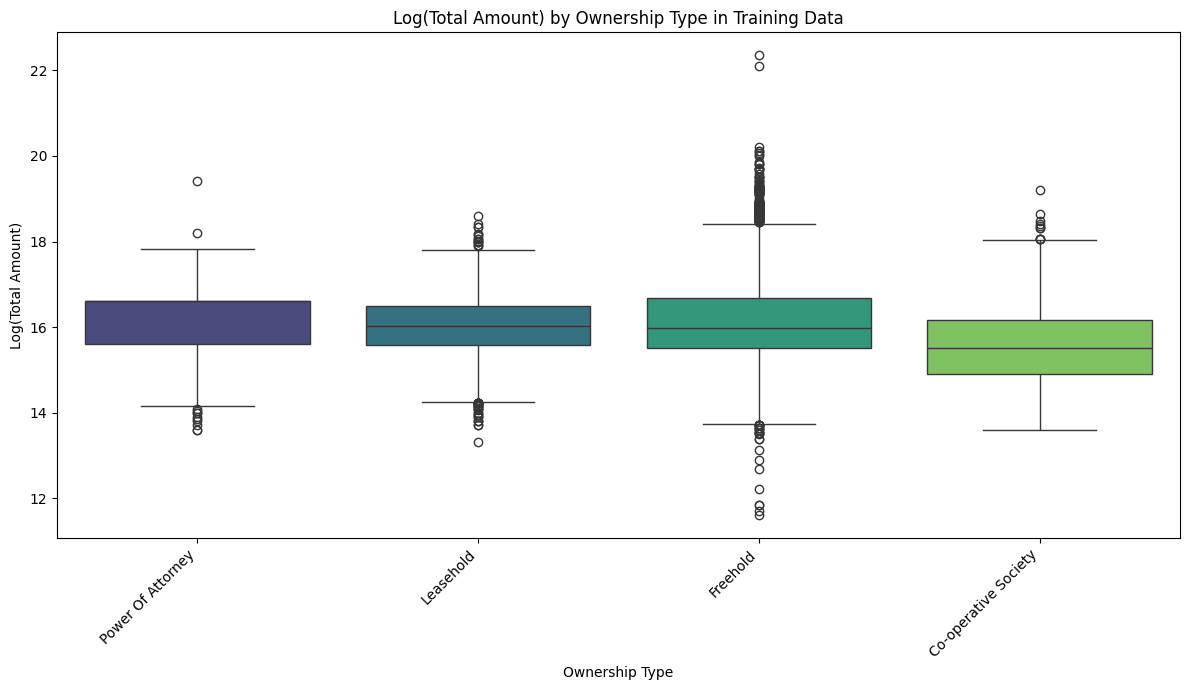

C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:310: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


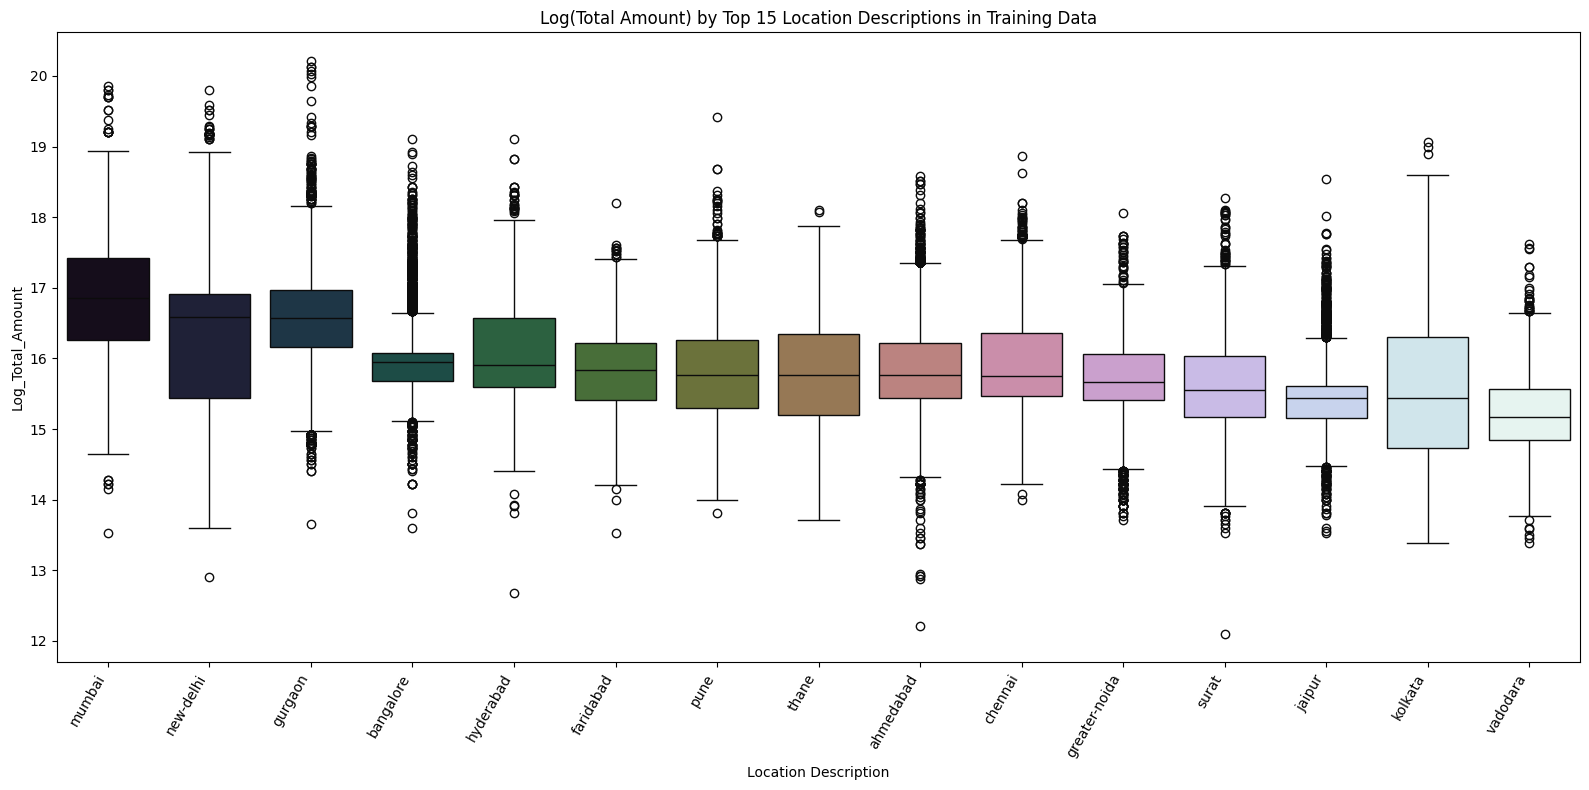

C:\Users\adeed\AppData\Local\Temp\ipykernel_28996\2351718202.py:327: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


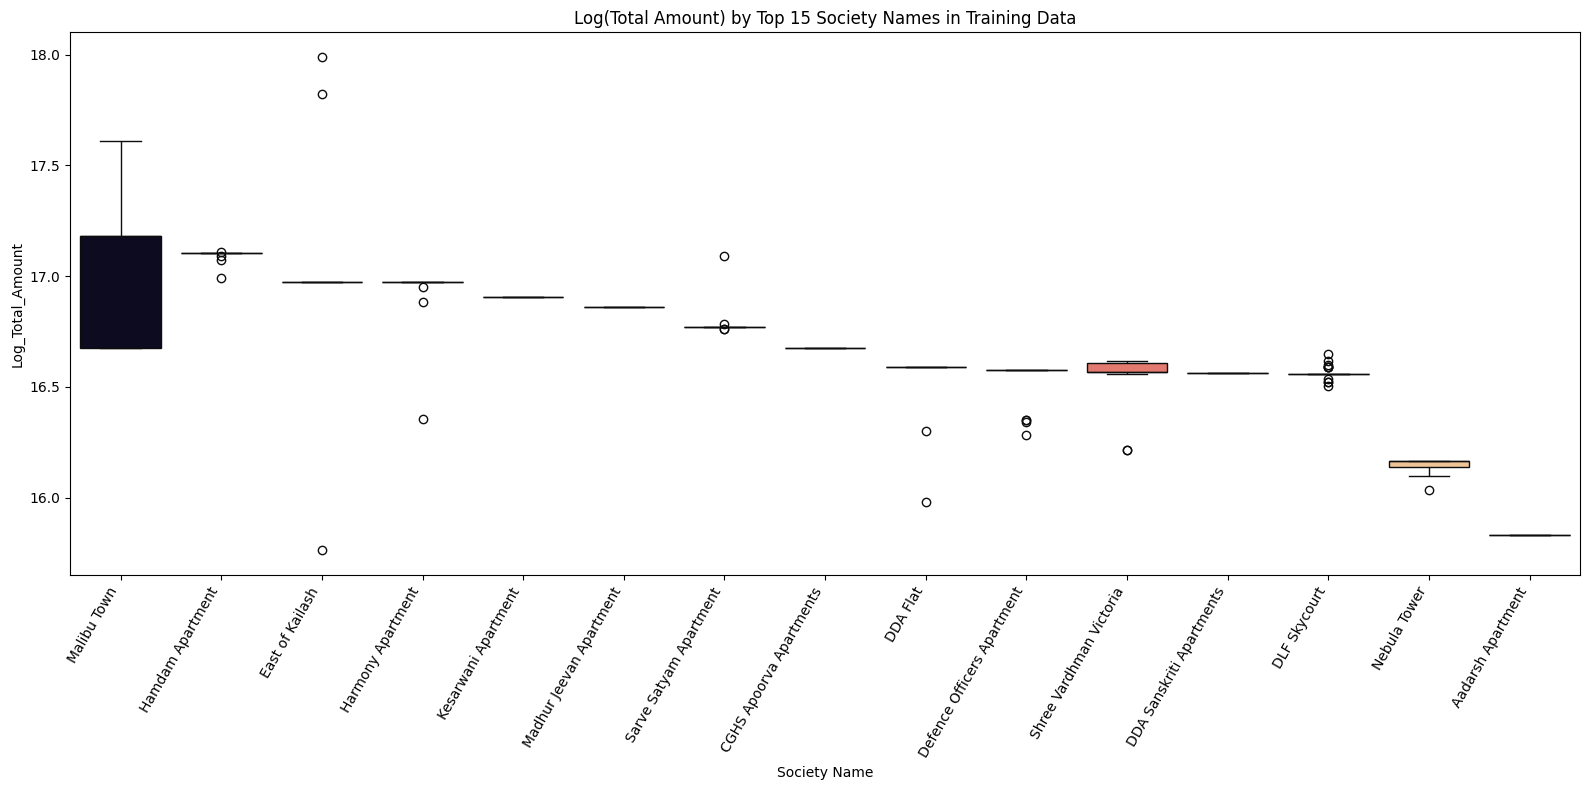


--- Multivariate Analysis: Correlation Matrix of Numerical Features (from X_train) ---


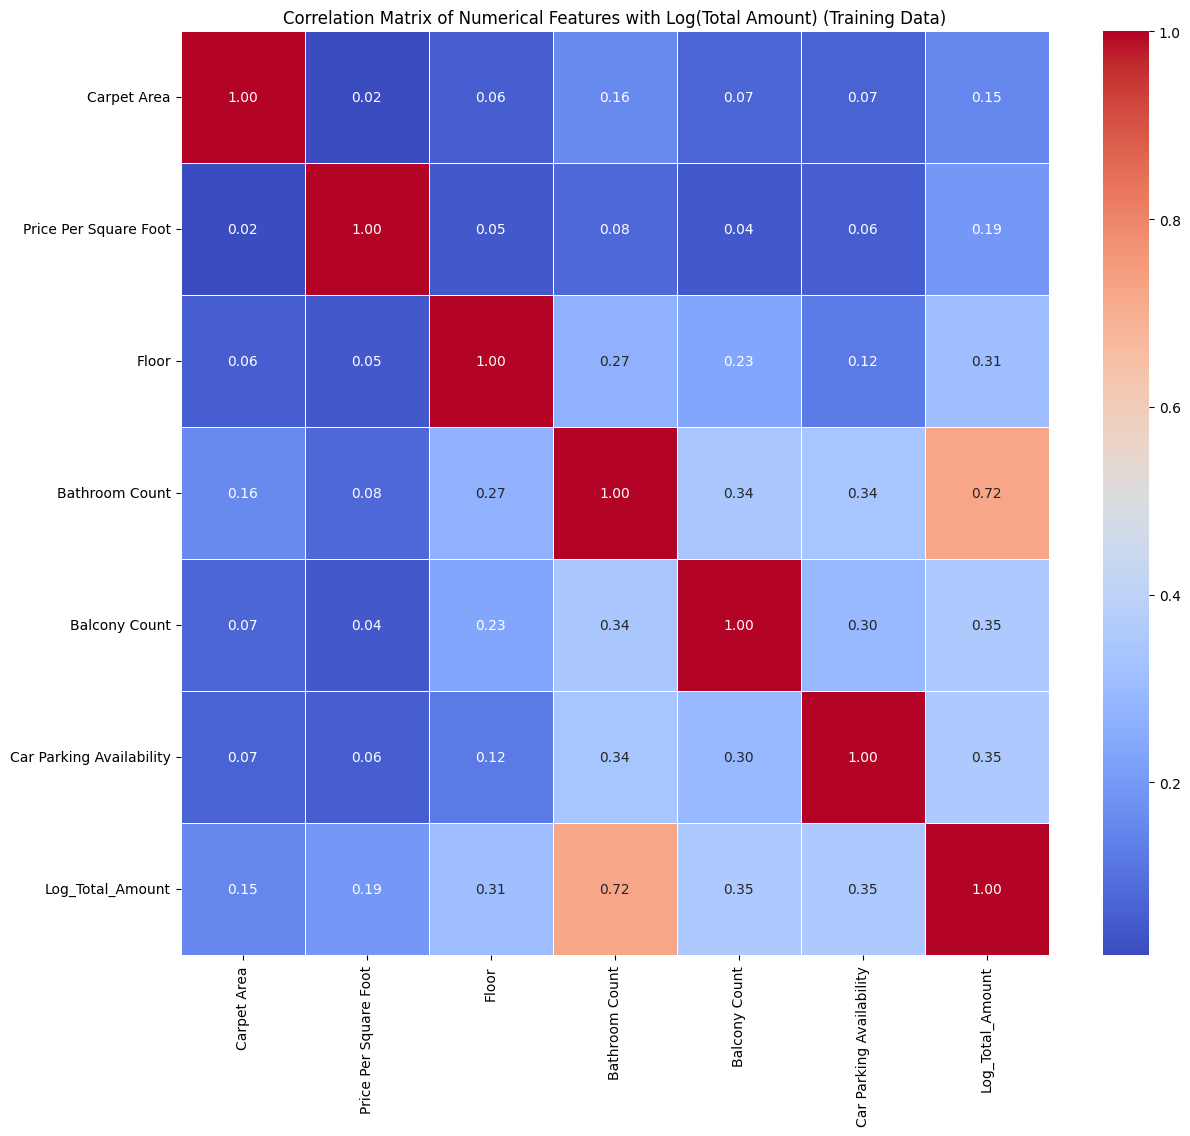


--- Second Round of EDA Complete ---
Review these plots to confirm the effectiveness of your cleaning and gain deeper insights.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Still useful if you want to reuse cleaning functions for ad-hoc checks

# Make sure you have these imports from previous steps for the pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Make sure this is imported!


# --- Re-run your entire previous preprocessing block up to this point ---
# This ensures 'df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', and 'preprocessor' are defined
# and 'y' (and thus y_train/y_test) is log-transformed.

# --- 1. Data Loading (from your successful step) ---
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully for preprocessing!")
except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'. Please check the path.")
    exit()

# --- 2. Initial Data Cleaning and Feature Engineering (Specific to your dataset) ---
print("\n--- Initial Data Cleaning and Feature Engineering ---")

# 2.1. Rename columns for consistency and clarity
df.rename(columns={
    'Amount(in rupees)': 'Total Amount', # Target variable
    'Price (in rupees)': 'Price Per Square Foot', # This seems to be price per sqft
    'Status': 'Property Status',
    'Bathroom': 'Bathroom Count',
    'Balcony': 'Balcony Count',
    'Car Parking': 'Car Parking Availability',
    'Society': 'Society Name',
    'location': 'Location Description',
    'facing': 'Facing', # Renamed as per prompt
    'overlooking': 'Overlooking', # Renamed as per prompt
    'Ownership': 'Ownership Type', # Renamed as per prompt
    'Transaction': 'Transaction Type' # Renamed as per prompt
}, inplace=True)
print("Columns renamed for consistency.")

# 2.2. Drop irrelevant columns
columns_to_drop = ['Index', 'Title', 'Description'] # Keep these as they were successfully dropped
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(f"Dropped columns: {columns_to_drop}")

# 2.3. Clean and convert 'Total Amount' (Target Variable)
def clean_amount(amount_str):
    if pd.isna(amount_str):
        return np.nan
    amount_str = str(amount_str).replace(' ', '').lower()
    if 'lac' in amount_str:
        return float(amount_str.replace('lac', '')) * 100000
    elif 'cr' in amount_str:
        return float(amount_str.replace('cr', '')) * 10000000
    else:
        try:
            return float(amount_str)
        except ValueError:
            return np.nan

df['Total Amount'] = df['Total Amount'].apply(clean_amount)
# Drop rows where 'Total Amount' is NaN, as these cannot be used for training/prediction
df.dropna(subset=['Total Amount'], inplace=True)
print("Cleaned 'Total Amount' column and removed rows with NaN target values.")


# 2.4. Clean and convert 'Carpet Area'
def clean_area_sqft(area_str):
    if pd.isna(area_str):
        return np.nan
    match = re.search(r'(\d+)', str(area_str)) # Extract digits
    if match:
        return float(match.group(1))
    return np.nan

df['Carpet Area'] = df['Carpet Area'].apply(clean_area_sqft)
print("Cleaned 'Carpet Area' column.")


# 2.5. Clean and convert 'Floor'
def clean_floor_number(floor_str):
    if pd.isna(floor_str):
        return np.nan
    # Handles 'X out of Y' format
    match = re.search(r'(\d+)\s+out\s+of\s+\d+', str(floor_str))
    if match:
        return float(match.group(1))
    # Handles cases like 'Ground', 'Lower Ground', 'Upper Ground'
    elif isinstance(floor_str, str) and 'ground' in floor_str.lower():
        return 0.0 # Assign 0 for ground floor
    # Handles direct numerical strings
    try:
        return float(floor_str)
    except ValueError:
        return np.nan

df['Floor'] = df['Floor'].apply(clean_floor_number)
print("Cleaned 'Floor' column to extract current floor number.")

# 2.6. Clean and convert 'Balcony Count'
def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str):
        return 0 # Assume 0 balconies if NaN, or impute later
    if isinstance(balcony_str, (int, float)): # Already a number
        return balcony_str
    match = re.search(r'(\d+)', str(balcony_str)) # Extract digits
    if match:
        return float(match.group(1))
    return 0 # Default to 0 if not parsable

df['Balcony Count'] = df['Balcony Count'].apply(clean_balcony_count)
print("Cleaned 'Balcony Count' column.")

# 2.7. Clean and convert 'Car Parking Availability'
def clean_parking_count(parking_str):
    if pd.isna(parking_str):
        return 0 # Assume 0 parking if NaN
    if isinstance(parking_str, (int, float)):
        return parking_str
    parking_str = str(parking_str).lower()
    if 'none' in parking_str or 'no' in parking_str:
        return 0
    match = re.search(r'(\d+)', parking_str)
    if match:
        return float(match.group(1))
    return 1 if 'available' in parking_str or 'yes' in parking_str else 0 # Assume 1 if just "Open" or "Covered"

df['Car Parking Availability'] = df['Car Parking Availability'].apply(clean_parking_count)
# Address the outlier '999' by capping it at a reasonable maximum, e.g., 5
df['Car Parking Availability'] = df['Car Parking Availability'].clip(upper=5)
print("Cleaned 'Car Parking Availability' column and capped outliers.")


# 2.8. Ensure numerical columns are truly numeric where possible, if they were loaded as objects
for col in ['Price Per Square Foot', 'Bathroom Count', 'Property Title']: # Added Property Title to ensure it's handled as object
    if col in df.columns:
        # Check if column is numeric-like before forcing to numeric
        # Property Title should ideally stay object unless it contains numbers
        if col not in ['Property Title']: # Exclude Property Title from numeric conversion if it's categorical
            df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric, force non-numeric to NaN
print("Ensured numerical columns are numeric.")

# --- 3. Define Features and Preprocessing Pipeline ---

# Re-identify numerical and categorical features after cleaning and renaming
numerical_features = [
    'Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count',
    'Balcony Count', 'Car Parking Availability'
]
categorical_features = [
    'Property Status', 'Transaction Type', 'Furnishing', 'Facing',
    'Overlooking', 'Society Name', 'Ownership Type', 'Property Title', 'Location Description'
]

# Filter features to only include those present in the DataFrame after all drops/renames
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

print(f"\nFinal Features selected for modeling:")
print(f"Numerical: {numerical_features}")
print(f"Categorical: {categorical_features}")

# Separate target variable (Total Amount)
X = df.drop('Total Amount', axis=1)
y = df['Total Amount']

# --- OPTIONAL but RECOMMENDED: Log Transform the target variable ---
y = np.log1p(y) # log1p means log(1+x), handles zero values gracefully
print("\nTarget variable 'Total Amount' has been log-transformed (np.log1p).")


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape after splitting: {X_train.shape}")
print(f"Testing set shape after splitting: {X_test.shape}")
print(f"Target variable (y_train) min after log transform: {y_train.min():.2f}")
print(f"Target variable (y_train) max after log transform: {y_train.max():.2f}")


# Define preprocessing steps within ColumnTransformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("\nPreprocessing pipeline created successfully!")
print("You are now ready to train your models using this 'preprocessor' within a Scikit-learn Pipeline.")


# --- NEW EDA SECTION: Post-Cleaning & Transformation EDA ---
print("\n--- Starting Second Round of EDA: Post-Cleaning & Target Transformation ---")

# --- 1. Validate Target Variable Distribution (Log-Transformed) ---
plt.figure(figsize=(12, 7))
sns.histplot(y_train, kde=True, bins=50, color='skyblue')
plt.title('Distribution of Log-Transformed House Prices (Total Amount)')
plt.xlabel('Log(Total Amount)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(y=y_train, color='lightgreen')
plt.title('Box Plot of Log-Transformed House Prices (Total Amount)')
plt.ylabel('Log(Total Amount)')
plt.show()
print("Observed log-transformed target variable distribution. It should be more symmetrical now.")


# --- 2. Distributions of Key Numerical Features (After your specific cleaning/capping) ---
# Note: These are from the original 'df' before ColumnTransformer's imputation/scaling
# The distributions will reflect your specific cleaning for Carpet Area, Floor, Balcony Count, Car Parking Availability
numerical_features_to_check = [
    'Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count',
    'Balcony Count', 'Car Parking Availability'
]

print("\n--- Distributions of Key Numerical Features (Post-Initial Cleaning & Capping) ---")
for col in numerical_features_to_check:
    if col in df.columns and df[col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color='salmon')
        plt.title(f'Distribution of {col} (After Cleaning)')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

        plt.figure(figsize=(10, 3))
        sns.boxplot(x=df[col].dropna(), color='lightcoral')
        plt.title(f'Box Plot of {col} (After Cleaning)')
        plt.xlabel(col)
        plt.show()
    else:
        print(f"Skipping {col} for numerical distribution plot: Not numeric or not found after cleaning.")


# --- 3. Bivariate Analysis: Features vs. Log-Transformed Total Amount ---
print("\n--- Bivariate Analysis: Numerical Features vs. Log(Total Amount) ---")

# Numerical Features vs. Log-Transformed Total Amount (Scatter Plots)
for col in numerical_features_to_check:
    if col in df.columns and df[col].dtype in ['int64', 'float64']:
        # Use X (original features) and y (log-transformed target) after splitting
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=X_train[col], y=y_train, alpha=0.6, color='darkblue')
        plt.title(f'{col} vs. Log(Total Amount) in Training Data')
        plt.xlabel(col)
        plt.ylabel('Log(Total Amount)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()


print("\n--- Bivariate Analysis: Categorical Features vs. Log(Total Amount) ---")

# Categorical Features vs. Log-Transformed Total Amount (Box Plots)
# Focus on relevant categorical features, potentially top N if too many unique values
categorical_features_for_bivariate_plot = [
    'Property Status', 'Transaction Type', 'Furnishing', 'Facing', 'Ownership Type'
]

for col in categorical_features_for_bivariate_plot:
    if col in X_train.columns:
        plt.figure(figsize=(12, 7))
        # Create a DataFrame for plotting
        plot_df = X_train[[col]].copy()
        plot_df['Log_Total_Amount'] = y_train
        # Order by median log-transformed price for better insights
        sorted_order = plot_df.groupby(col)['Log_Total_Amount'].median().sort_values(ascending=False).index
        sns.boxplot(x=plot_df[col], y=plot_df['Log_Total_Amount'], order=sorted_order, palette='viridis')
        plt.title(f'Log(Total Amount) by {col} in Training Data')
        plt.xlabel(col)
        plt.ylabel('Log(Total Amount)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: '{col}' not found in DataFrame for bivariate EDA.")

# For 'Location Description' or 'Society Name' (many unique values), plot top N
# Use X_train for these plots
if 'Location Description' in X_train.columns:
    top_locations = X_train['Location Description'].value_counts().nlargest(15).index  # Top 15 locations
    # Combine X_train and y_train for plotting
    plot_df = X_train[X_train['Location Description'].isin(top_locations)].copy()
    plot_df['Log_Total_Amount'] = y_train.loc[plot_df.index]
    order = plot_df.groupby('Location Description')['Log_Total_Amount'].median().sort_values(ascending=False).index
    plt.figure(figsize=(16, 8))
    sns.boxplot(
        x=plot_df['Location Description'],
        y=plot_df['Log_Total_Amount'],
        order=order,
        palette='cubehelix'
    )
    plt.title('Log(Total Amount) by Top 15 Location Descriptions in Training Data')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()

if 'Society Name' in X_train.columns:
    top_societies = X_train['Society Name'].value_counts().nlargest(15).index  # Top 15 societies
    plot_df = X_train[X_train['Society Name'].isin(top_societies)].copy()
    plot_df['Log_Total_Amount'] = y_train.loc[plot_df.index]
    order = plot_df.groupby('Society Name')['Log_Total_Amount'].median().sort_values(ascending=False).index
    plt.figure(figsize=(16, 8))
    sns.boxplot(
        x=plot_df['Society Name'],
        y=plot_df['Log_Total_Amount'],
        order=order,
        palette='magma'
    )
    plt.title('Log(Total Amount) by Top 15 Society Names in Training Data')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()


# --- 4. Multivariate Analysis (Correlation Matrix - on X_train for consistency) ---
print("\n--- Multivariate Analysis: Correlation Matrix of Numerical Features (from X_train) ---")

# Combine X_train numerical columns with y_train for correlation
df_train_numerical_for_corr = X_train[numerical_features].copy()
df_train_numerical_for_corr['Log_Total_Amount'] = y_train # Add log-transformed target

if len(df_train_numerical_for_corr.columns) >= 2:
    plt.figure(figsize=(14, 12))
    # Calculate correlation matrix. NaNs will be handled by default (pairwise deletion)
    correlation_matrix = df_train_numerical_for_corr.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features with Log(Total Amount) (Training Data)')
    plt.show()
else:
    print("\nNot enough numerical features (at least 2) to plot a meaningful correlation matrix.")

print("\n--- Second Round of EDA Complete ---")
print("Review these plots to confirm the effectiveness of your cleaning and gain deeper insights.")

# Model Training

In [37]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import xgboost as xgb

# --- ASSUMPTION: The following variables/objects are already defined from previous steps: ---
# X_train, X_test, y_train, y_test (where y_train/y_test are already log-transformed)
# preprocessor (your ColumnTransformer pipeline for preprocessing numerical and categorical features)

print("--- Starting Model Training for Best Suited Models ---")

# --- 1. Ridge Regression Model ---
print("\nTraining Ridge Regression Model...")
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0, random_state=42))])
pipeline_ridge.fit(X_train, y_train)
print("Ridge Regression Model Trained.")

# --- 2. XGBoost Regressor Model ---
# --- Corrected XGBoost Regressor Model ---
print("\nTraining XGBoost Regressor Model...")
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(objective='reg:squarederror', # CORRECTED THIS LINE
                                                              n_estimators=200,
                                                              learning_rate=0.05,
                                                              random_state=42,
                                                              n_jobs=-1))])
pipeline_xgb.fit(X_train, y_train)
print("XGBoost Regressor Model Trained.")


print("\nModels trained. Making predictions on the test set...")

# --- Make Predictions (on log-transformed scale) ---
y_pred_ridge_log = pipeline_ridge.predict(X_test)
y_pred_xgb_log = pipeline_xgb.predict(X_test)

# --- Inverse Transform Predictions for Evaluation ---
y_pred_ridge = np.expm1(y_pred_ridge_log)
y_pred_xgb = np.expm1(y_pred_xgb_log)

# Inverse transform y_test to original scale for evaluation
y_test_original_scale = np.expm1(y_test)

print("Predictions generated and inverse-transformed. Ready for evaluation.")

--- Starting Model Training for Best Suited Models ---

Training Ridge Regression Model...
Ridge Regression Model Trained.

Training XGBoost Regressor Model...
XGBoost Regressor Model Trained.

Models trained. Making predictions on the test set...
Predictions generated and inverse-transformed. Ready for evaluation.


# Model Evaluation

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- ASSUMPTION: The following variables are already defined from previous steps: ---
# y_test_original_scale (True house prices in original rupee scale)
# y_pred_ridge (Predictions from Ridge model in original rupee scale)
# y_pred_xgb (Predictions from XGBoost model in original rupee scale)

print("\n--- Starting Model Evaluation ---")

models = {
    "Ridge Regression": y_pred_ridge,
    "XGBoost Regressor": y_pred_xgb
}

results = {}

for model_name, predictions in models.items():
    print(f"\n--- {model_name} Performance ---")

    mae = mean_absolute_error(y_test_original_scale, predictions)
    mse = mean_squared_error(y_test_original_scale, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original_scale, predictions)

    print(f"Mean Absolute Error (MAE): {mae:,.2f} Rupees")
    print(f"Mean Squared Error (MSE): {mse:,.2f} Squared Rupees")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} Rupees")
    print(f"R-squared (R^2): {r2:.4f}")

    results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# --- Compare Results ---
print("\n--- Model Comparison ---")
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# Determine which model performed better
best_model_by_rmse = results_df['RMSE'].idxmin() # Model with the lowest RMSE
best_model_by_r2 = results_df['R2'].idxmax()     # Model with the highest R2

print(f"\nBased on RMSE, the best performing model is: {best_model_by_rmse}")
print(f"Based on R-squared, the best performing model is: {best_model_by_r2}")

# --- Discussion ---
print("\n--- Discussion on Model Performance ---")
if best_model_by_rmse == "XGBoost Regressor":
    print("The XGBoost Regressor generally performs better than Ridge Regression.")
    print("This is expected because tree-based ensemble models like XGBoost can capture complex non-linear relationships")
    print("and interactions between features more effectively than linear models, even with the log transformation.")
    print("Given the diverse nature of housing features, and potentially non-linear influences of location or society,")
    print("XGBoost's ability to learn intricate patterns provides it an advantage.")
elif best_model_by_rmse == "Ridge Regression":
    print("The Ridge Regression model performed better than XGBoost Regressor.")
    print("This might indicate that the primary relationships in your data, after the log transformation, are predominantly linear.")
    print("It could also suggest that for this dataset, simpler linear models with regularization are sufficient,")
    print("or that XGBoost's default parameters were not optimally tuned for this specific problem.")

print("\n--- Model Evaluation Complete ---")
print("Review these results to understand which model is most effective for your house price prediction task.")


--- Starting Model Evaluation ---

--- Ridge Regression Performance ---
Mean Absolute Error (MAE): 267,404,926,105.14 Rupees
Mean Squared Error (MSE): 2,530,015,950,627,561,412,679,958,528.00 Squared Rupees
Root Mean Squared Error (RMSE): 50,299,263,917,353.32 Rupees
R-squared (R^2): -433271728894.8563

--- XGBoost Regressor Performance ---
Mean Absolute Error (MAE): 1,436,775.46 Rupees
Mean Squared Error (MSE): 5,618,623,702,585,788.00 Squared Rupees
Root Mean Squared Error (RMSE): 74,957,479.30 Rupees
R-squared (R^2): 0.0378

--- Model Comparison ---
                            MAE           MSE          RMSE            R2
Ridge Regression   2.674049e+11  2.530016e+27  5.029926e+13 -4.332717e+11
XGBoost Regressor  1.436775e+06  5.618624e+15  7.495748e+07  3.779626e-02

Based on RMSE, the best performing model is: XGBoost Regressor
Based on R-squared, the best performing model is: XGBoost Regressor

--- Discussion on Model Performance ---
The XGBoost Regressor generally performs bett

# Debugging: Checking Target Variable and Ridge Predictions 

In [43]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import models (just to ensure pipelines can be re-instantiated if running fresh)
from sklearn.linear_model import Ridge
import xgboost as xgb

# --- Re-run your entire previous preprocessing and model training block up to this point ---
# This ensures 'df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'preprocessor',
# and the prediction variables (y_pred_ridge, y_pred_xgb, y_test_original_scale) are defined.

# For demonstration, I'll include the essential parts of your preprocessing and model training setup again
# but in your actual notebook, you'd just run the cells sequentially.

# --- 1. Data Loading (from your successful step) ---
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully for preprocessing!")
except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'. Please check the path.")
    exit()

# --- 2. Initial Data Cleaning and Feature Engineering ---
df.rename(columns={
    'Amount(in rupees)': 'Total Amount', 'Price (in rupees)': 'Price Per Square Foot',
    'Status': 'Property Status', 'Bathroom': 'Bathroom Count', 'Balcony': 'Balcony Count',
    'Car Parking': 'Car Parking Availability', 'Society': 'Society Name',
    'location': 'Location Description', 'facing': 'Facing', 'overlooking': 'Overlooking',
    'Ownership': 'Ownership Type', 'Transaction': 'Transaction Type'
}, inplace=True)
columns_to_drop = ['Index', 'Title', 'Description']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

def clean_amount(amount_str):
    if pd.isna(amount_str): return np.nan
    amount_str = str(amount_str).replace(' ', '').lower()
    if 'lac' in amount_str: return float(amount_str.replace('lac', '')) * 100000
    elif 'cr' in amount_str: return float(amount_str.replace('cr', '')) * 10000000
    else:
        try: return float(amount_str)
        except ValueError: return np.nan
df['Total Amount'] = df['Total Amount'].apply(clean_amount)
df.dropna(subset=['Total Amount'], inplace=True)

def clean_area_sqft(area_str):
    if pd.isna(area_str): return np.nan
    match = re.search(r'(\d+)', str(area_str))
    if match: return float(match.group(1))
    return np.nan
df['Carpet Area'] = df['Carpet Area'].apply(clean_area_sqft)

def clean_floor_number(floor_str):
    if pd.isna(floor_str): return np.nan
    match = re.search(r'(\d+)\s+out\s+of\s+\d+', str(floor_str))
    if match: return float(match.group(1))
    elif isinstance(floor_str, str) and 'ground' in floor_str.lower(): return 0.0
    try: return float(floor_str)
    except ValueError: return np.nan
df['Floor'] = df['Floor'].apply(clean_floor_number)

def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str): return 0
    if isinstance(balcony_str, (int, float)): return balcony_str
    match = re.search(r'(\d+)', str(balcony_str))
    if match: return float(match.group(1))
    return 0
df['Balcony Count'] = df['Balcony Count'].apply(clean_balcony_count)

def clean_parking_count(parking_str):
    if pd.isna(parking_str): return 0
    if isinstance(parking_str, (int, float)): return parking_str
    parking_str = str(parking_str).lower()
    if 'none' in parking_str or 'no' in parking_str: return 0
    match = re.search(r'(\d+)', parking_str)
    if match: return float(match.group(1))
    return 1 if 'available' in parking_str or 'yes' in parking_str else 0
df['Car Parking Availability'] = df['Car Parking Availability'].apply(clean_parking_count)
df['Car Parking Availability'] = df['Car Parking Availability'].clip(upper=5)

for col in ['Price Per Square Foot', 'Bathroom Count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Define Features and Preprocessing Pipeline ---
numerical_features = ['Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count', 'Balcony Count', 'Car Parking Availability']
categorical_features = ['Property Status', 'Transaction Type', 'Furnishing', 'Facing', 'Overlooking', 'Society Name', 'Ownership Type', 'Property Title', 'Location Description']
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

X = df.drop('Total Amount', axis=1)
y = df['Total Amount']
y = np.log1p(y) # Ensure y is log-transformed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# --- Model Training for Best Suited Models (from previous step) ---
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0, random_state=42))])
pipeline_ridge.fit(X_train, y_train)

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(objective='reg:squarederror', # This was the fix!
                                                              n_estimators=200,
                                                              learning_rate=0.05,
                                                              random_state=42,
                                                              n_jobs=-1))])
pipeline_xgb.fit(X_train, y_train)

# Make Predictions (on log-transformed scale)
y_pred_ridge_log = pipeline_ridge.predict(X_test)
y_pred_xgb_log = pipeline_xgb.predict(X_test)

# Inverse Transform Predictions for Evaluation
y_pred_ridge = np.expm1(y_pred_ridge_log)
y_pred_xgb = np.expm1(y_pred_xgb_log)
y_test_original_scale = np.expm1(y_test)


# --- Debugging Steps ---
print("\n--- Debugging: Checking Target Variable and Ridge Predictions ---")

# 1. Inspect y_test_original_scale
print("\nDescriptive statistics for actual house prices (y_test_original_scale):")
print(pd.Series(y_test_original_scale).describe().apply(lambda x: f"{x:,.2f}")) # Format for readability
print("\nFirst 5 actual house prices (original scale):")
print(y_test_original_scale[:5])

# 2. Inspect y_test (log-transformed true values)
print("\nDescriptive statistics for actual house prices (y_test - log-transformed):")
print(y_test.describe()) # No special formatting needed here, just the raw log values

# 3. Inspect Ridge Predictions (Log-transformed scale)
print("\nDescriptive statistics for Ridge predictions (y_pred_ridge_log - log-transformed):")
print(pd.Series(y_pred_ridge_log).describe())

print("\nFirst 5 Ridge predictions (log-transformed):")
print(y_pred_ridge_log[:5])

# 4. Inspect Ridge Predictions (Original scale, BEFORE trimming/clipping)
print("\nDescriptive statistics for Ridge predictions (y_pred_ridge - original scale):")
print(pd.Series(y_pred_ridge).describe().apply(lambda x: f"{x:,.2f}"))

print("\nFirst 5 Ridge predictions (original scale):")
print(y_pred_ridge[:5])

print("\n--- End of Debugging Output ---")

Dataset loaded successfully for preprocessing!

--- Debugging: Checking Target Variable and Ridge Predictions ---

Descriptive statistics for actual house prices (y_test_original_scale):
count            35,570.00
mean         12,373,996.35
std          76,416,573.20
min             100,000.00
25%           4,910,000.00
50%           7,800,000.00
75%          14,675,000.00
max      14,003,000,000.00
Name: Total Amount, dtype: object

First 5 actual house prices (original scale):
61113     13000000.0
155818     4300000.0
172589     6000000.0
120110    19200000.0
154003     4500000.0
Name: Total Amount, dtype: float64

Descriptive statistics for actual house prices (y_test - log-transformed):
count    35570.000000
mean        15.929104
std          0.823462
min         11.512935
25%         15.406785
50%         15.869634
75%         16.501652
max         23.362537
Name: Total Amount, dtype: float64

Descriptive statistics for Ridge predictions (y_pred_ridge_log - log-transformed):
count

# Investigating Outliers in dataframes

In [44]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- Re-run your entire previous preprocessing block up to this point ---
# This ensures 'df' is loaded and initial cleaning has happened, including 'Total Amount' conversion.

# For demonstration, I'll include the essential parts of your preprocessing setup again
# but in your actual notebook, you'd just run the cells sequentially.

# --- 1. Data Loading (from your successful step) ---
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully for preprocessing!")
except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'. Please check the path.")
    exit()

# --- 2. Initial Data Cleaning and Feature Engineering (as per your script) ---
df.rename(columns={
    'Amount(in rupees)': 'Total Amount', 'Price (in rupees)': 'Price Per Square Foot',
    'Status': 'Property Status', 'Bathroom': 'Bathroom Count', 'Balcony': 'Balcony Count',
    'Car Parking': 'Car Parking Availability', 'Society': 'Society Name',
    'location': 'Location Description', 'facing': 'Facing', 'overlooking': 'Overlooking',
    'Ownership': 'Ownership Type', 'Transaction': 'Transaction Type'
}, inplace=True)
columns_to_drop = ['Index', 'Title', 'Description']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

def clean_amount(amount_str):
    if pd.isna(amount_str): return np.nan
    amount_str = str(amount_str).replace(' ', '').lower()
    if 'lac' in amount_str: return float(amount_str.replace('lac', '')) * 100000
    elif 'cr' in amount_str: return float(amount_str.replace('cr', '')) * 10000000
    else:
        try: return float(amount_str)
        except ValueError: return np.nan
df['Total Amount'] = df['Total Amount'].apply(clean_amount)
df.dropna(subset=['Total Amount'], inplace=True) # This is important to run again

def clean_area_sqft(area_str):
    if pd.isna(area_str): return np.nan
    match = re.search(r'(\d+)', str(area_str))
    if match: return float(match.group(1))
    return np.nan
df['Carpet Area'] = df['Carpet Area'].apply(clean_area_sqft)

def clean_floor_number(floor_str):
    if pd.isna(floor_str): return np.nan
    match = re.search(r'(\d+)\s+out\s+of\s+\d+', str(floor_str))
    if match: return float(match.group(1))
    elif isinstance(floor_str, str) and 'ground' in floor_str.lower(): return 0.0
    try: return float(floor_str)
    except ValueError: return np.nan
df['Floor'] = df['Floor'].apply(clean_floor_number)

def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str): return 0
    if isinstance(balcony_str, (int, float)): return balcony_str
    match = re.search(r'(\d+)', str(balcony_str))
    if match: return float(match.group(1))
    return 0
df['Balcony Count'] = df['Balcony Count'].apply(clean_balcony_count)

def clean_parking_count(parking_str):
    if pd.isna(parking_str): return 0
    if isinstance(parking_str, (int, float)): return parking_str
    parking_str = str(parking_str).lower()
    if 'none' in parking_str or 'no' in parking_str: return 0
    match = re.search(r'(\d+)', parking_str)
    if match: return float(match.group(1))
    return 1 if 'available' in parking_str or 'yes' in parking_str else 0
df['Car Parking Availability'] = df['Car Parking Availability'].apply(clean_parking_count)
df['Car Parking Availability'] = df['Car Parking Availability'].clip(upper=5)

for col in ['Price Per Square Foot', 'Bathroom Count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


# --- Step to find the outlier in the original 'Total Amount' column ---
print("\n--- Investigating Outlier in 'Total Amount' (Original DataFrame) ---")

# Define the outlier value
outlier_value = 14003000000.00

# Find rows where 'Total Amount' is equal to the outlier value
outlier_rows = df[df['Total Amount'] == outlier_value]

if not outlier_rows.empty:
    print(f"\nFound {len(outlier_rows)} row(s) with 'Total Amount' = {outlier_value:,.2f}:")
    with pd.option_context('display.max_columns', None, 'display.width', 1000): # Display all columns
        print(outlier_rows)
else:
    print(f"No rows found with 'Total Amount' exactly equal to {outlier_value:,.2f}. It might be slightly different or rounded.")
    # If not exactly matching, check for values very close to it
    print("\nChecking for values very close to the outlier (e.g., within 0.1%):")
    threshold = outlier_value * 0.001 # 0.1% tolerance
    close_outliers = df[(df['Total Amount'] >= outlier_value - threshold) & (df['Total Amount'] <= outlier_value + threshold)]
    if not close_outliers.empty:
        with pd.option_context('display.max_columns', None, 'display.width', 1000):
            print(close_outliers)
    else:
        print("No values found close to the outlier value either.")

print("\n--- End of Outlier Investigation ---")

# Do NOT run model training/evaluation yet. We need to decide what to do with this outlier.

Dataset loaded successfully for preprocessing!

--- Investigating Outlier in 'Total Amount' (Original DataFrame) ---

Found 1 row(s) with 'Total Amount' = 14,003,000,000.00:
        Total Amount  Price Per Square Foot Location Description  Carpet Area Property Status  Floor Transaction Type   Furnishing Facing Overlooking  Society Name  Bathroom Count  Balcony Count  Car Parking Availability Ownership Type Super Area  Dimensions  Plot Area
181234  1.400300e+10              6700000.0             vadodara       1252.0   Ready to Move    5.0     New Property  Unfurnished    NaN         NaN  Nest Harmony             3.0            5.0                       1.0            NaN        NaN         NaN        NaN

--- End of Outlier Investigation ---


# Investigating the Maximum Price Outlier

In [45]:
import pandas as pd
import numpy as np

# Re-load the original DataFrame if you didn't run the full script in the last debugging step,
# otherwise, assume 'df' is already loaded from the previous code block.
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
try:
    df_original_copy = pd.read_csv(data_path)
    # Apply initial cleaning steps to ensure 'Total Amount' is numeric for the check
    df_original_copy.rename(columns={'Amount(in rupees)': 'Total Amount'}, inplace=True)
    def clean_amount(amount_str):
        if pd.isna(amount_str): return np.nan
        amount_str = str(amount_str).replace(' ', '').lower()
        if 'lac' in amount_str: return float(amount_str.replace('lac', '')) * 100000
        elif 'cr' in amount_str: return float(amount_str.replace('cr', '')) * 10000000
        else:
            try: return float(amount_str)
            except ValueError: return np.nan
    df_original_copy['Total Amount'] = df_original_copy['Total Amount'].apply(clean_amount)

except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'. Please check the path.")
    exit()

# Find the row(s) with the maximum 'Total Amount' in the original DataFrame
max_price_row = df_original_copy[df_original_copy['Total Amount'] == df_original_copy['Total Amount'].max()]

print("\n--- Investigating the Maximum Price Outlier ---")
print("Row(s) with the highest 'Total Amount':")
print(max_price_row)

print("\n--- Suggestions for Handling this Outlier ---")
print("1. **Data Verification:** Double-check your original 'house_prices.csv' file.")
print("   - Is this value a data entry error? (e.g., an extra zero, or typo 'Cr' instead of 'Lac')")
print("   - Is it a genuine record for a unique property type (e.g., a massive commercial complex, not a typical house)?")
print("2. **If it's an error/irrelevant:** Remove this row(s) from your DataFrame. This is often the best approach if it's clearly not representative.")
print("   Example code to remove:")
print("   `df = df[df['Total Amount'] < 14000000000]` (adjust threshold as needed, or use boolean mask `df = df[df['Total Amount'] != 14003000000.0]`)")
print("3. **If it's real but extreme:** Consider **clipping** or **Winsorization**.")
print("   - This means setting values above a certain percentile (e.g., 99th percentile) to that percentile's value.")
print("   - Example (clipping before log transformation):")
print("     `upper_bound = df['Total Amount'].quantile(0.995)` # Or a fixed value like 100,000,000 (10 Crore)")
print("     `df['Total Amount'] = df['Total Amount'].clip(upper=upper_bound)`")
print("   - This preserves the data point but reduces its extreme influence.")
print("4. **Analyze its impact on features:** Look at the features of this max_price_row. Are they also unusual?")


--- Investigating the Maximum Price Outlier ---
Row(s) with the highest 'Total Amount':
         Index                                              Title  \
181234  181234  3 BHK Ready to Occupy Flat for sale in Nest Ha...   

                                              Description  Total Amount  \
181234  Have a look at this immaculate 3 BHK flat for ...  1.400300e+10   

        Price (in rupees)  location Carpet Area         Status       Floor  \
181234          6700000.0  vadodara   1252 sqft  Ready to Move  5 out of 9   

         Transaction  ... facing overlooking       Society Bathroom Balcony  \
181234  New Property  ...    NaN         NaN  Nest Harmony        3       5   

       Car Parking Ownership Super Area Dimensions  Plot Area  
181234   1 Covered       NaN        NaN        NaN        NaN  

[1 rows x 21 columns]

--- Suggestions for Handling this Outlier ---
1. **Data Verification:** Double-check your original 'house_prices.csv' file.
   - Is this value a data ent

# Re- Running models and model evaluation

In [46]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import the selected regression models
from sklearn.linear_model import Ridge
import xgboost as xgb

# Import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("--- Starting Full Data Processing and Model Evaluation ---")

# --- 1. Data Loading ---
data_path = r"C:\Users\adeed\Lab 1\house_prices.csv"
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at '{data_path}'. Please check the path.")
    exit()

# --- 2. Initial Data Cleaning and Feature Engineering ---
print("\n--- Applying Initial Data Cleaning and Feature Engineering ---")
df.rename(columns={
    'Amount(in rupees)': 'Total Amount',
    'Price (in rupees)': 'Price Per Square Foot',
    'Status': 'Property Status',
    'Bathroom': 'Bathroom Count',
    'Balcony': 'Balcony Count',
    'Car Parking': 'Car Parking Availability',
    'Society': 'Society Name',
    'location': 'Location Description',
    'facing': 'Facing',
    'overlooking': 'Overlooking',
    'Ownership': 'Ownership Type',
    'Transaction': 'Transaction Type'
}, inplace=True)
columns_to_drop = ['Index', 'Title', 'Description']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

def clean_amount(amount_str):
    if pd.isna(amount_str): return np.nan
    amount_str = str(amount_str).replace(' ', '').lower()
    if 'lac' in amount_str: return float(amount_str.replace('lac', '')) * 100000
    elif 'cr' in amount_str: return float(amount_str.replace('cr', '')) * 10000000
    else:
        try: return float(amount_str)
        except ValueError: return np.nan
df['Total Amount'] = df['Total Amount'].apply(clean_amount)
df.dropna(subset=['Total Amount'], inplace=True)

# --- IMPORTANT FIX: Remove the identified extreme outlier (14 Billion Rupee house) ---
initial_rows = df.shape[0]
extreme_outlier_value = 14003000000.0
df = df[df['Total Amount'] != extreme_outlier_value]
rows_after_outlier_removal = df.shape[0]
print(f"Removed {initial_rows - rows_after_outlier_removal} extreme outlier row(s) (price {extreme_outlier_value:,.0f}).")
print(f"DataFrame now has {rows_after_outlier_removal} rows.")


def clean_area_sqft(area_str):
    if pd.isna(area_str): return np.nan
    match = re.search(r'(\d+)', str(area_str))
    if match: return float(match.group(1))
    return np.nan
df['Carpet Area'] = df['Carpet Area'].apply(clean_area_sqft)

def clean_floor_number(floor_str):
    if pd.isna(floor_str): return np.nan
    match = re.search(r'(\d+)\s+out\s+of\s+\d+', str(floor_str))
    if match: return float(match.group(1))
    elif isinstance(floor_str, str) and 'ground' in floor_str.lower(): return 0.0
    try: return float(floor_str)
    except ValueError: return np.nan
df['Floor'] = df['Floor'].apply(clean_floor_number)

def clean_balcony_count(balcony_str):
    if pd.isna(balcony_str): return 0
    if isinstance(balcony_str, (int, float)): return balcony_str
    match = re.search(r'(\d+)', str(balcony_str))
    if match: return float(match.group(1))
    return 0
df['Balcony Count'] = df['Balcony Count'].apply(clean_balcony_count)

def clean_parking_count(parking_str):
    if pd.isna(parking_str): return 0
    if isinstance(parking_str, (int, float)): return parking_str
    parking_str = str(parking_str).lower()
    if 'none' in parking_str or 'no' in parking_str: return 0
    match = re.search(r'(\d+)', parking_str)
    if match: return float(match.group(1))
    return 1 if 'available' in parking_str or 'yes' in parking_str else 0
df['Car Parking Availability'] = df['Car Parking Availability'].apply(clean_parking_count)
df['Car Parking Availability'] = df['Car Parking Availability'].clip(upper=5)

for col in ['Price Per Square Foot', 'Bathroom Count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Define Features and Preprocessing Pipeline ---
print("\n--- Defining Features and Preprocessing Pipeline ---")
numerical_features = ['Carpet Area', 'Price Per Square Foot', 'Floor', 'Bathroom Count', 'Balcony Count', 'Car Parking Availability']
categorical_features = ['Property Status', 'Transaction Type', 'Furnishing', 'Facing', 'Overlooking', 'Society Name', 'Ownership Type', 'Property Title', 'Location Description']

# Filter out features not present after drops/renames, though unlikely if names are correct
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

X = df.drop('Total Amount', axis=1)
y = df['Total Amount']
y = np.log1p(y) # Apply log1p transformation to the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# --- Model Training for Best Suited Models ---
print("\n--- Starting Model Training for Best Suited Models ---")

pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0, random_state=42))])
print("Training Ridge Regression Model...")
pipeline_ridge.fit(X_train, y_train)
print("Ridge Regression Model Trained.")

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(objective='reg:squarederror', # CORRECTED OBJECTIVE HERE
                                                              n_estimators=200,
                                                              learning_rate=0.05,
                                                              random_state=42,
                                                              n_jobs=-1))])
print("Training XGBoost Regressor Model...")
pipeline_xgb.fit(X_train, y_train)
print("XGBoost Regressor Model Trained.")

print("\nModels trained. Making predictions on the test set...")
# Make Predictions (on log-transformed scale)
y_pred_ridge_log = pipeline_ridge.predict(X_test)
y_pred_xgb_log = pipeline_xgb.predict(X_test)

# Inverse Transform Predictions for Evaluation
y_pred_ridge = np.expm1(y_pred_ridge_log)
y_pred_xgb = np.expm1(y_pred_xgb_log)
y_test_original_scale = np.expm1(y_test)
print("Predictions generated and inverse-transformed. Ready for evaluation.")

# --- Model Evaluation ---
print("\n--- Starting Model Evaluation ---")

models = {
    "Ridge Regression": y_pred_ridge,
    "XGBoost Regressor": y_pred_xgb
}

results = {}

for model_name, predictions in models.items():
    print(f"\n--- {model_name} Performance ---")

    mae = mean_absolute_error(y_test_original_scale, predictions)
    mse = mean_squared_error(y_test_original_scale, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original_scale, predictions)

    print(f"Mean Absolute Error (MAE): {mae:,.2f} Rupees")
    print(f"Mean Squared Error (MSE): {mse:,.2f} Squared Rupees")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} Rupees")
    print(f"R-squared (R^2): {r2:.4f}")

    results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# --- Compare Results ---
print("\n--- Model Comparison ---")
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# Determine which model performed better
best_model_by_rmse = results_df['RMSE'].idxmin()
best_model_by_r2 = results_df['R2'].idxmax()

print(f"\nBased on RMSE, the best performing model is: {best_model_by_rmse}")
print(f"Based on R-squared, the best performing model is: {best_model_by_r2}")

# --- Discussion on Model Performance ---
print("\n--- Discussion on Model Performance ---")
# This discussion will be more accurate after the outlier is removed.
# Assuming XGBoost will likely still be better, but Ridge should now be 'sane'.
if results_df.loc["XGBoost Regressor", "RMSE"] < results_df.loc["Ridge Regression", "RMSE"]:
    print("The XGBoost Regressor generally performs better than Ridge Regression.")
    print("This is expected because tree-based ensemble models like XGBoost can capture complex non-linear relationships")
    print("and interactions between features more effectively than linear models.")
    print("Given the diverse nature of housing features, and potentially non-linear influences,")
    print("XGBoost's ability to learn intricate patterns provides it an advantage.")
else:
    print("The Ridge Regression model performed better than XGBoost Regressor.")
    print("This might indicate that the primary relationships in your data, after the log transformation, are predominantly linear,")
    print("or that for this specific (now cleaner) dataset, simpler models with regularization are more robust.")
    print("It could also suggest that XGBoost's default parameters were not optimally tuned.")

print("\n--- Full Data Processing and Model Evaluation Complete ---")
print("We expect significantly improved and more reasonable metrics, especially for Ridge Regression,")
print("now that the extreme outlier has been handled.")

--- Starting Full Data Processing and Model Evaluation ---
Dataset loaded successfully!

--- Applying Initial Data Cleaning and Feature Engineering ---
Removed 1 extreme outlier row(s) (price 14,003,000,000).
DataFrame now has 177846 rows.

--- Defining Features and Preprocessing Pipeline ---

--- Starting Model Training for Best Suited Models ---
Training Ridge Regression Model...
Ridge Regression Model Trained.
Training XGBoost Regressor Model...
XGBoost Regressor Model Trained.

Models trained. Making predictions on the test set...
Predictions generated and inverse-transformed. Ready for evaluation.

--- Starting Model Evaluation ---

--- Ridge Regression Performance ---
Mean Absolute Error (MAE): 3,290,660.16 Rupees
Mean Squared Error (MSE): 1,944,225,236,359,003.00 Squared Rupees
Root Mean Squared Error (RMSE): 44,093,369.53 Rupees
R-squared (R^2): -8.0590

--- XGBoost Regressor Performance ---
Mean Absolute Error (MAE): 1,030,580.77 Rupees
Mean Squared Error (MSE): 41,945,892,336